<a href="https://colab.research.google.com/github/m-anderson9/taskmanager/blob/main/Clubselector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===== ALL-IN-ONE (YARDS): Tee+Green → Draw FW (polyline OR polygon) + OB line + other polygons → Probabilities + Aim Sweep =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"                # internal CRS (metres)
yd2m = 0.9144                           # yards → metres

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards). Edit if your fairway is wider/narrower.
FAIRWAY_LINE_TOTAL_YDS = 30.0           # e.g. 30 yds total (±15 yds)

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip all geometry to this hole’s corridor (metres)
CORRIDOR_CLIP_M     = 80.0

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}

# Aim sweep (yards; − = aim LEFT, + = aim RIGHT)
AIM_SWEEP_YDS = np.arange(-20, 22, 2)

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    # heal hairline gaps
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2 = cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        # Start as ROUGH; carve in priority order
        spans=[(0,2*half,"rough")]
        spans = carve(cross, ob,      "ob",      spans)   # crossing the line = OB
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        # merge like-labeled neighbours; convert to signed lateral metres
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)
    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in stations:
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections[s]:
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)
    return out

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

# Draw selector — FAIRWAY can be POLYLINE or POLYGON; OB is LINE; others POLYGONS
label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored.")
            return
        user_lines["fairway"].append(geom); print("Captured fairway LINE")
        return

    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored.")
            return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON")
        return

    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored.")
            return
        user_lines["ob"].append(geom); print("Captured OB LINE")
        return

    # Others must be polygons
    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored.")
        return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")

        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")

        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")

        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")

        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buff_


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00
Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

Clicked: 55.805840, -4.074200  (#1)
Clicked: 55.808095, -4.075885  (#2)
Clicked: 55.807980, -4.076003  (#2)
Clicked: 55.807492, -4.075767  (#2)
Clicked: 55.807413, -4.075638  (#2)
Clicked: 55.807287, -4.075692  (#2)
Clicked: 55.806732, -4.075295  (#2)
Clicked: 55.806111, -4.074512  (#2)
Clicked: 55.806129, -4.074265  (#2)
Clicked: 55.806569, -4.074544  (#2)
Clicked: 55.807033, -4.074951  (#2)
Clicked: 55.807504, -4.075423  (#2)
Clicked: 55.807829, -4.075563  (#2)
Clicked: 55.808028, -4.075649  (#2)
Captured fairway POLYGON
Clicked: 55.807404, -4.075788  (#2)
Clicked: 55.807409, -4.075729  (#2)
Clicked: 55.807321, -4.075719  (#2)
Clicked: 55.807311, -4.075769  (#2)
Captured bunker POLYGON
Clicked: 55.807136, -4.074820  (#2)
Clicked: 55.807106, -4.074807  (#2)
Clicked: 55.807106, -4.074866  (#2)
Clicked: 55.807159, -4.074922  (#2)
Captured bunker POLYGON
Captured bunker POLYGON
Clicked: 55.807582, -4.075225  (#2)
Captured recovery POLYGON
Clicked: 55.807585, -4.075206  (#2)
Clicked: 55.8

In [ ]:
# ===== ALL-IN-ONE (YARDS): Tee+Green → Draw FW (polyline OR polygon) + OB line + other polygons → Probabilities + Aim Sweep =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"                # internal CRS (metres)
yd2m = 0.9144                           # yards → metres

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards). Edit if your fairway is wider/narrower.
FAIRWAY_LINE_TOTAL_YDS = 30.0           # e.g. 30 yds total (±15 yds)

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip all geometry to this hole’s corridor (metres)
CORRIDOR_CLIP_M     = 80.0

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}

# Aim sweep (yards; − = aim LEFT, + = aim RIGHT)
AIM_SWEEP_YDS = np.arange(-20, 22, 2)

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    # heal hairline gaps
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2 = cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        # Start as ROUGH; carve in priority order
        spans=[(0,2*half,"rough")]
        spans = carve(cross, ob,      "ob",      spans)   # crossing the line = OB
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        # merge like-labeled neighbours; convert to signed lateral metres
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)
    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in stations:
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections[s]:
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)
    return out

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

# Draw selector — FAIRWAY can be POLYLINE or POLYGON; OB is LINE; others POLYGONS
label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored.")
            return
        user_lines["fairway"].append(geom); print("Captured fairway LINE")
        return

    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored.")
            return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON")
        return

    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored.")
            return
        user_lines["ob"].append(geom); print("Captured OB LINE")
        return

    # Others must be polygons
    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored.")
        return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")

        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")

        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")

        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")

        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)  # 30 cm band so cross-sections “hit” the boundary
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Build centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip everything to this hole’s corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway if still none (use centreline corridor with fairway-line width)
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Shape summary
        def _area(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.area)
        def _len(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.length)
        print("\nShape summary (metres):")
        print(f"  Fairway area:  { _area(fw_use):.1f} m²")
        print(f"  Bunkers area:  { _area(bunkers_use):.1f} m²")
        print(f"  Penalty area:  { _area(penalty_use):.1f} m²")
        print(f"  Water area:    { _area(water_use):.1f} m²")
        print(f"  Recovery area: { _area(recovery_use):.1f} m²")
        print(f"  OB length:     { _len(ob_geom):.1f} m")

        # ---- Draw centreline preview
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5))
        tee_ll = (tee.y, tee.x); green_ll = (green.y, green.x)
        m2 = folium.Map(location=tee_ll, zoom_start=16, tiles="OpenStreetMap", control_scale=True)
        folium.Marker(tee_ll, tooltip="Tee").add_to(m2); folium.Marker(green_ll, tooltip="Green").add_to(m2)
        folium.PolyLine([(lat,lon) for lon,lat in cl_ll.coords], weight=5).add_to(m2)
        display(m2)

        # ---- Cross-sections & probabilities
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        # Build lookup
        sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                    for s, g in df_long.groupby("station_m")}
        stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0

        # Baseline (centred aim)
        print("\nLanding probabilities on this hole (%):")
        for name, cfg in CLUBS.items():
            r = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0)
            pretty = " | ".join([f"{lab:8s} {r.get(lab,0):5.1f}%" for lab in LABELS])
            print(f"{name:7s}: {pretty}")

        # Aim sweep
        print("\nAim sweep (− left / + right) [yards]:")
        for name, cfg in CLUBS.items():
            rows=[]
            for a in AIM_SWEEP_YDS:
                r = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=a)
                # disaster = penalty + water + OB
                rows.append({"aim_yds":a, **r, "disaster": r["penalty"] + r["water"] + r["ob"],
                             "balanced": r["fairway"] - 1.0*r["bunker"] - 3.0*(r["penalty"]+r["water"]+r["ob"]) - 0.5*r["recovery"]})
            df = pd.DataFrame(rows)
            best_fair = df.loc[df["fairway"].idxmax()]
            best_safe = df.loc[df["disaster"].idxmin()]
            best_bal  = df.loc[df["balanced"].idxmax()]
            print(f"\n{name} recommended aims (yds from centreline):")
            print(f"  Max Fairway% : aim {best_fair['aim_yds']:+.0f} | Fairway {best_fair['fairway']:.1f}% | Disaster {best_fair['disaster']:.1f}%")
            print(f"  Min Disaster : aim {best_safe['aim_yds']:+.0f} | Fairway {best_safe['fairway']:.1f}% | Disaster {best_safe['disaster']:.1f}%")
            print(f"  Balanced     : aim {best_bal['aim_yds']:+.0f} | Fairway {best_bal['fairway']:.1f}% | Disaster {best_bal['disaster']:.1f}% | Bunker {best_bal['bunker']:.1f}% | Recovery {best_bal['recovery']:.1f}%")

            plt.figure(figsize=(8,3))
            plt.plot(df["aim_yds"], df["fairway"], label="Fairway %")
            plt.plot(df["aim_yds"], df["disaster"], label="Penalty+Water+OB %")
            plt.plot(df["aim_yds"], df["recovery"], label="Recovery %")
            plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Probability (%)")
            plt.title(f"Aim sweep — {name}"); plt.legend(); plt.show()

run_btn.on_click(process)

print("👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.")
print("   If you use a fairway polyline, it's buffered to a polygon using FAIRWAY_LINE_TOTAL_YDS (edit at top). Inputs in YARDS; geometry runs in metres.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00
Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.
   If you use a fairway polyline, it's buffered to a polygon using FAIRWAY_LINE_TOTAL_YDS (edit at top). Inputs in YARDS; geometry runs in metres.
Clicked: 55.805864, -4.074211  (#1)
Clicked: 55.808107, -4.075874  (#2)
Clicked: 55.807962, -4.076024  (#2)
Clicked: 55.807437, -4.075660  (#2)
Clicked: 55.807323, -4.075627  (#2)
Clicked: 55.807244, -4.075713  (#2)
Clicked: 55.806834, -4.075381  (#2)
Clicked: 55.806690, -4.075016  (#2)
Clicked: 55.806304, -4.074672  (#2)
Clicked: 55.806093, -4.074415  (#2)
Clicked: 55.806388, -4.074351  (#2)
Clicked: 55.806828, -4.074726  (#2)
Clicked: 55.807576, -4.075391  (#2)
Clicked: 55.808016, -4.075660  (#2)
Captured fairway POLYGON
Captured fairway POLYGON
Captured bunker POLYGON
Captured bunker POLYGON
Captured bunker POLYGON


In [ ]:
# ===== ALL-IN-ONE (YARDS): FW polyline or polygon + OB line + others → Probabilities in a landing window + Aim Sweep =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"                # internal CRS (metres)
yd2m = 0.9144                           # yards → metres

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards). Edit if your fairway is wider/narrower.
FAIRWAY_LINE_TOTAL_YDS = 30.0           # e.g. 30 yds total (±15 yds)

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip all geometry to this hole’s corridor (metres)
CORRIDOR_CLIP_M     = 80.0

# ---- NEW: Only score where shots actually land
SIGMA_MULT          = 2.5      # window = mean_stop ± SIGMA_MULT * sigma_long
MIN_WINDOW_YDS      = 25.0     # but never smaller than this (per side)

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}

# Aim sweep (yards; − = aim LEFT, + = aim RIGHT)
AIM_SWEEP_YDS = np.arange(-20, 22, 2)

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        # Start as ROUGH everywhere (so "rest is rough"), then carve:
        spans=[(0,2*half,"rough")]
        spans = carve(cross, ob,      "ob",      spans)   # boundary crossings
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        # merge like-labeled neighbours; convert to signed lateral metres
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def fairway_width_at_station(sections, s):
    """Return total fairway width (metres) at station s (sum of fairway spans)."""
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    # --- NEW: restrict to landing window around mean stop distance
    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations)==0:
        use_stations = stations  # fallback

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in use_stations:
        # longitudinal weight
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections[s]:
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)

    # also return diagnostics
    # station with max longitudinal weight within window
    if len(use_stations):
        idx = np.argmax([np.exp(-0.5*((s-mu_s)/sig_s)**2) for s in use_stations])
        s_peak = float(use_stations[idx])
        fw_w_m = fairway_width_at_station(sections, s_peak)
    else:
        s_peak, fw_w_m = float(mu_s), 0.0
    return out, {"s_peak_m": s_peak, "fw_width_yds": fw_w_m/yd2m}

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

# Draw selector — FAIRWAY can be POLYLINE or POLYGON; OB is LINE; others POLYGONS
label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored.")
            return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored.")
            return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored.")
            return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)  # 30 cm band so cross-sections “hit” the boundary
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Build centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip everything to this hole’s corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway if still none (use centreline corridor with fairway-line width)
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Shape summary
        def _area(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.area)
        def _len(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.length)
        print("\nShape summary (metres):")
        print(f"  Fairway area:  { _area(fw_use):.1f} m²")
        print(f"  Bunkers area:  { _area(bunkers_use):.1f} m²")
        print(f"  Penalty area:  { _area(penalty_use):.1f} m²")
        print(f"  Water area:    { _area(water_use):.1f} m²")
        print(f"  Recovery area: { _area(recovery_use):.1f} m²")
        print(f"  OB length:     { _len(ob_geom):.1f} m")

        # ---- Draw centreline preview
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5))
        tee_ll = (tee.y, tee.x); green_ll = (green.y, green.x)
        m2 = folium.Map(location=tee_ll, zoom_start=16, tiles="OpenStreetMap", control_scale=True)
        folium.Marker(tee_ll, tooltip="Tee").add_to(m2); folium.Marker(green_ll, tooltip="Green").add_to(m2)
        folium.PolyLine([(lat,lon) for lon,lat in cl_ll.coords], weight=5).add_to(m2)
        display(m2)

        # ---- Cross-sections & probabilities
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        # Build lookup
        sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                    for s, g in df_long.groupby("station_m")}
        stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0

        # Baseline (centred aim) with landing window + diagnostics
        print("\nLanding probabilities on this hole (%) [landing window applied]:")
        for name, cfg in CLUBS.items():
            res, diag = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0)
            pretty = " | ".join([f"{lab:8s} {res.get(lab,0):5.1f}%" for lab in LABELS])
            print(f"{name:7s}: {pretty}")
            print(f"   ↳ at peak distance ~{diag['s_peak_m']/yd2m:,.0f} yds, fairway width ≈ {diag['fw_width_yds']:.1f} yds")

        # Aim sweep
        print("\nAim sweep (− left / + right) [yards] (landing window applied):")
        for name, cfg in CLUBS.items():
            rows=[]
            for a in AIM_SWEEP_YDS:
                res, _ = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=a)
                rows.append({"aim_yds":a, **res, "disaster": res["penalty"] + res["water"] + res["ob"],
                             "balanced": res["fairway"] - 1.0*res["bunker"] - 3.0*(res["penalty"]+res["water"]+res["ob"]) - 0.5*res["recovery"]})
            df = pd.DataFrame(rows)
            best_fair = df.loc[df["fairway"].idxmax()]
            best_safe = df.loc[df["disaster"].idxmin()]
            best_bal  = df.loc[df["balanced"].idxmax()]
            print(f"\n{name} recommended aims (yds from centreline):")
            print(f"  Max Fairway% : aim {best_fair['aim_yds']:+.0f} | Fairway {best_fair['fairway']:.1f}% | Disaster {best_fair['disaster']:.1f}%")
            print(f"  Min Disaster : aim {best_safe['aim_yds']:+.0f} | Fairway {best_safe['fairway']:.1f}% | Disaster {best_safe['disaster']:.1f}%")
            print(f"  Balanced     : aim {best_bal['aim_yds']:+.0f} | Fairway {best_bal['fairway']:.1f}% | Disaster {best_bal['disaster']:.1f}% | Bunker {best_bal['bunker']:.1f}% | Recovery {best_bal['recovery']:.1f}%")

            plt.figure(figsize=(8,3))
            plt.plot(df["aim_yds"], df["fairway"], label="Fairway %")
            plt.plot(df["aim_yds"], df["disaster"], label="Penalty+Water+OB %")
            plt.plot(df["aim_yds"], df["recovery"], label="Recovery %")
            plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Probability (%)")
            plt.title(f"Aim sweep — {name}"); plt.legend(); plt.show()

run_btn.on_click(process)

print("👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.")
print("   Probabilities are computed only near your landing distance (±max(25 yds, 2.5σ_long)). 'Rest is rough' is enforced by default.")


Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.
   Probabilities are computed only near your landing distance (±max(25 yds, 2.5σ_long)). 'Rest is rough' is enforced by default.
Clicked: 55.805852, -4.074168  (#1)
Clicked: 55.808095, -4.075885  (#2)
Clicked: 55.807992, -4.076024  (#2)
Clicked: 55.808040, -4.075649  (#2)
Clicked: 55.807329, -4.075273  (#2)
Clicked: 55.806967, -4.074866  (#2)
Clicked: 55.806678, -4.074630  (#2)
Clicked: 55.806147, -4.074233  (#2)
Clicked: 55.806105, -4.074426  (#2)
Clicked: 55.806280, -4.074694  (#2)
Clicked: 55.806455, -4.074866  (#2)
Clicked: 55.806636, -4.075145  (#2)
Clicked: 55.806786, -4.075338  (#2)
Clicked: 55.806943, -4.075509  (#2)
Clicked: 55.807172, -4.075702  (#2)
Clicked: 55.807269, -4.075719  (#2)
Clicked: 55.807321, -4.075670  (#2)
Clicked: 55.807421, -4.075676  (#2)
Clicked: 55.807462, -4.075759 

In [ ]:
# ===== ALL-IN-ONE (YARDS): Draw FW (polyline or polygon) + OB line + other polygons → Probabilities (with landing-window) + Aim Sweep =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"                # internal CRS (metres)
yd2m = 0.9144                           # yards → metres

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards). Edit if your fairway is wider/narrower.
FAIRWAY_LINE_TOTAL_YDS = 30.0           # e.g. 30 yds total (±15 yds)

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip all geometry to THIS hole’s corridor (metres) — we will still clip your full fairway
CORRIDOR_CLIP_M     = 80.0

# ---- Landing-window scoring (per club)
SIGMA_MULT          = 2.5      # window = mean_stop ± SIGMA_MULT * sigma_long
MIN_WINDOW_YDS      = 25.0     # but never smaller than this (per side)

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}

# Aim sweep (yards; − = aim LEFT, + = aim RIGHT)
AIM_SWEEP_YDS = np.arange(-20, 22, 2)
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        # Start as ROUGH everywhere (so "rest is rough"), then carve:
        spans=[(0,2*half,"rough")]
        spans = carve(cross, ob,      "ob",      spans)   # boundary crossings
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        # merge like-labeled neighbours; convert to signed lateral metres
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

def fairway_width_at_station(sections, s):
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0, warn_prefix=""):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    used_full = False
    if len(use_stations) == 0:
        use_stations = stations
        used_full = True

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in use_stations:
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections[s]:
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)

    # diagnostics
    if len(use_stations):
        idx = np.argmax([np.exp(-0.5*((s-mu_s)/sig_s)**2) for s in use_stations])
        s_peak = float(use_stations[idx])
        fw_w_m = fairway_width_at_station(sections, s_peak)
    else:
        s_peak, fw_w_m = float(mu_s), 0.0
    diag = {"used_full": used_full, "s_peak_m": s_peak, "fw_width_yds": fw_w_m/yd2m}
    return out, diag

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)  # 30 cm band so cross-sections “hit” the boundary
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Build centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip everything to this hole’s corridor (so you can draw full fairway; we still focus on this hole)
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway if still none (use centreline corridor with fairway-line width)
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Shape summary
        def _area(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.area)
        def _len(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.length)
        print("\nShape summary (metres):")
        print(f"  Fairway area:  { _area(fw_use):.1f} m²")
        print(f"  Bunkers area:  { _area(bunkers_use):.1f} m²")
        print(f"  Penalty area:  { _area(penalty_use):.1f} m²")
        print(f"  Water area:    { _area(water_use):.1f} m²")
        print(f"  Recovery area: { _area(recovery_use):.1f} m²")
        print(f"  OB length:     { _len(ob_geom):.1f} m")

        # ---- Draw centreline preview
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5))
        tee_ll = (tee.y, tee.x); green_ll = (green.y, green.x)
        m2 = folium.Map(location=tee_ll, zoom_start=16, tiles="OpenStreetMap", control_scale=True)
        folium.Marker(tee_ll, tooltip="Tee").add_to(m2); folium.Marker(green_ll, tooltip="Green").add_to(m2)
        folium.PolyLine([(lat,lon) for lon,lat in cl_ll.coords], weight=5).add_to(m2)
        display(m2)

        # ---- Cross-sections & probabilities
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        # Build lookup
        sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                    for s, g in df_long.groupby("station_m")}
        stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0

        if len(stations) == 0:
            print("⚠️ Could not build cross-sections on this geometry. Try redrawing the fairway closer to centreline.")
            return

        # Baseline (centred aim) with landing window + diagnostics; ALWAYS print (fallback to full centreline if needed)
        print("\nLanding probabilities on this hole (%) [landing window applied]:")
        for name, cfg in CLUBS.items():
            res, diag = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0)
            if diag["used_full"]:
                print(f"⚠️ {name}: No stations in landing window — used full centreline for probabilities.")
            pretty = " | ".join([f"{lab:8s} {res.get(lab,0):5.1f}%" for lab in LABELS])
            print(f"{name:7s}: {pretty}")
            print(f"   ↳ at peak distance ~{diag['s_peak_m']/yd2m:,.0f} yds, fairway width ≈ {diag['fw_width_yds']:.1f} yds")

        # Aim sweep
        print("\nAim sweep (− left / + right) [yards] (landing window applied):")
        for name, cfg in CLUBS.items():
            rows=[]
            for a in AIM_SWEEP_YDS:
                res, _ = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=a)
                rows.append({"aim_yds":a, **res, "disaster": res["penalty"] + res["water"] + res["ob"],
                             "balanced": res["fairway"] - 1.0*res["bunker"] - 3.0*(res["penalty"]+res["water"]+res["ob"]) - 0.5*res["recovery"]})
            df = pd.DataFrame(rows)
            best_fair = df.loc[df["fairway"].idxmax()]
            best_safe = df.loc[df["disaster"].idxmin()]
            best_bal  = df.loc[df["balanced"].idxmax()]
            print(f"\n{name} recommended aims (yds from centreline):")
            print(f"  Max Fairway% : aim {best_fair['aim_yds']:+.0f} | Fairway {best_fair['fairway']:.1f}% | Disaster {best_fair['disaster']:.1f}%")
            print(f"  Min Disaster : aim {best_safe['aim_yds']:+.0f} | Fairway {best_safe['fairway']:.1f}% | Disaster {best_safe['disaster']:.1f}%")
            print(f"  Balanced     : aim {best_bal['aim_yds']:+.0f} | Fairway {best_bal['fairway']:.1f}% | Disaster {best_bal['disaster']:.1f}% | Bunker {best_bal['bunker']:.1f}% | Recovery {best_bal['recovery']:.1f}%")

            plt.figure(figsize=(8,3))
            plt.plot(df["aim_yds"], df["fairway"], label="Fairway %")
            plt.plot(df["aim_yds"], df["disaster"], label="Penalty+Water+OB %")
            plt.plot(df["aim_yds"], df["recovery"], label="Recovery %")
            plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Probability (%)")
            plt.title(f"Aim sweep — {name}"); plt.legend(); plt.show()

run_btn.on_click(process)

print("👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.")
print("   You can outline the FULL fairway; the script clips it to this hole’s corridor. Probabilities use a landing window per club.")


Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.
   You can outline the FULL fairway; the script clips it to this hole’s corridor. Probabilities use a landing window per club.
Clicked: 55.805834, -4.074190  (#1)
Clicked: 55.808077, -4.075896  (#2)
Clicked: 55.807998, -4.076003  (#2)
Clicked: 55.808019, -4.075643  (#2)
Clicked: 55.807486, -4.075343  (#2)
Clicked: 55.807024, -4.074962  (#2)
Clicked: 55.806856, -4.074721  (#2)
Clicked: 55.806590, -4.074560  (#2)
Clicked: 55.806165, -4.074265  (#2)
Clicked: 55.806114, -4.074313  (#2)
Clicked: 55.806114, -4.074506  (#2)
Clicked: 55.806283, -4.074705  (#2)
Clicked: 55.806545, -4.074994  (#2)
Clicked: 55.806738, -4.075289  (#2)
Clicked: 55.806967, -4.075536  (#2)
Clicked: 55.807196, -4.075729  (#2)
Clicked: 55.807353, -4.075670  (#2)
Clicked: 55.807419, -4.075649  (#2)
Clicked: 55.807456, -4.075740  (

In [ ]:
# ===== ALL-IN-ONE (robust) — Always prints probabilities, with window + section diagnostics =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"
yd2m = 0.9144

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards).
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip width around this hole
CORRIDOR_CLIP_M     = 120.0   # widened from 80 → 120 m

# Landing-window scoring (per club)
SIGMA_MULT          = 2.5
MIN_WINDOW_YDS      = 25.0

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]   # "rest is rough"
        spans = carve(cross, ob,      "ob",      spans)
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))
def fairway_width_at_station(sections, s):
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    used_full = False
    if len(use_stations) == 0:
        print(f"⚠️ No stations in landing window [{(s_min/yd2m):.0f}, {(s_max/yd2m):.0f}] yds — using full centreline.")
        use_stations = stations
        used_full = True

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in use_stations:
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections.get(s, []):
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)

    # diagnostics
    if len(use_stations):
        idx = np.argmax([np.exp(-0.5*((s-mu_s)/sig_s)**2) for s in use_stations])
        s_peak = float(use_stations[idx]); fw_w_m = fairway_width_at_station(sections, s_peak)
    else:
        s_peak, fw_w_m = float(mu_s), 0.0
    diag = {"used_full": used_full, "s_peak_m": s_peak, "fw_width_yds": fw_w_m/yd2m, "window_min_yds": s_min/yd2m, "window_max_yds": s_max/yd2m, "stations_used": len(use_stations)}
    return out, diag

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Build centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip to this hole
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Shape summary
        def _area(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.area)
        def _len(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.length)
        print("\nShape summary (metres):")
        print(f"  Fairway area:  { _area(fw_use):.1f} m²")
        print(f"  Bunkers area:  { _area(bunkers_use):.1f} m²")
        print(f"  Penalty area:  { _area(penalty_use):.1f} m²")
        print(f"  Water area:    { _area(water_use):.1f} m²")
        print(f"  Recovery area: { _area(recovery_use):.1f} m²")
        print(f"  OB length:     { _len(ob_geom):.1f} m")

        # ---- Centreline preview map
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5))
        tee_ll = (tee.y, tee.x); green_ll = (green.y, green.x)
        m2 = folium.Map(location=tee_ll, zoom_start=16, tiles="OpenStreetMap", control_scale=True)
        folium.Marker(tee_ll, tooltip="Tee").add_to(m2); folium.Marker(green_ll, tooltip="Green").add_to(m2)
        folium.PolyLine([(lat,lon) for lon,lat in cl_ll.coords], weight=5).add_to(m2)
        display(m2)

        # ---- Cross-sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        # Build lookup; if empty, synthesize rough-only sections so we still print probs
        if df_long is None or df_long.empty:
            print("⚠️ No intersections produced by your shapes. Using rough-only synthetic sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(s): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations available: {len(stations)} (step ≈ {ds:.1f} m)")

        if len(stations) == 0:
            print("⚠️ Could not build any stations. Try widening CORRIDOR_CLIP_M or redrawing shapes.")
            return

        # ---- Probabilities (with diagnostics)
        print("\nLanding probabilities on this hole (%) [landing window applied]:")
        for name, cfg in CLUBS.items():
            res, diag = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0)
            pretty = " | ".join([f"{lab:8s} {res.get(lab,0):5.1f}%" for lab in LABELS])
            print(f"{name:7s}: {pretty}")
            print(f"   ↳ window [{diag['window_min_yds']:.0f}, {diag['window_max_yds']:.0f}] yds | stations used: {diag['stations_used']}")
            print(f"   ↳ peak @ ~{diag['s_peak_m']/yd2m:,.0f} yds | fairway width ≈ {diag['fw_width_yds']:.1f} yds")

        # ---- Aim sweep
        print("\nAim sweep (− left / + right) [yards] (landing window applied):")
        for name, cfg in CLUBS.items():
            rows=[]
            for a in AIM_SWEEP_YDS:
                res, _ = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=a)
                rows.append({"aim_yds":a, **res, "disaster": res["penalty"] + res["water"] + res["ob"],
                             "balanced": res["fairway"] - 1.0*res["bunker"] - 3.0*(res["penalty"]+res["water"]+res["ob"]) - 0.5*res["recovery"]})
            df = pd.DataFrame(rows)
            best_fair = df.loc[df["fairway"].idxmax()]
            best_safe = df.loc[df["disaster"].idxmin()]
            best_bal  = df.loc[df["balanced"].idxmax()]
            print(f"\n{name} recommended aims (yds from centreline):")
            print(f"  Max Fairway% : aim {best_fair['aim_yds']:+.0f} | Fairway {best_fair['fairway']:.1f}% | Disaster {best_fair['disaster']:.1f}%")
            print(f"  Min Disaster : aim {best_safe['aim_yds']:+.0f} | Fairway {best_safe['fairway']:.1f}% | Disaster {best_safe['disaster']:.1f}%")
            print(f"  Balanced     : aim {best_bal['aim_yds']:+.0f} | Fairway {best_bal['fairway']:.1f}% | Disaster {best_bal['disaster']:.1f}% | Bunker {best_bal['bunker']:.1f}% | Recovery {best_bal['recovery']:.1f}%")

            plt.figure(figsize=(8,3))
            plt.plot(df["aim_yds"], df["fairway"], label="Fairway %")
            plt.plot(df["aim_yds"], df["disaster"], label="Penalty+Water+OB %")
            plt.plot(df["aim_yds"], df["recovery"], label="Recovery %")
            plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Probability (%)")
            plt.title(f"Aim sweep — {name}"); plt.legend(); plt.show()

run_btn.on_click(process)

print("👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.")
print("   If sections are empty, the script now falls back to rough-only synthetic sections and still prints probabilities with warnings.")


Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.
   If sections are empty, the script now falls back to rough-only synthetic sections and still prints probabilities with warnings.
Clicked: 55.805815, -4.074222  (#1)
Clicked: 55.808113, -4.075885  (#2)
Clicked: 55.808004, -4.075981  (#2)
Clicked: 55.807474, -4.075724  (#2)
Clicked: 55.807389, -4.075627  (#2)
Clicked: 55.807317, -4.075702  (#2)
Clicked: 55.807251, -4.075702  (#2)
Clicked: 55.807009, -4.075563  (#2)
Clicked: 55.806292, -4.074737  (#2)
Clicked: 55.806135, -4.074522  (#2)
Clicked: 55.806123, -4.074243  (#2)
Clicked: 55.806672, -4.074597  (#2)
Clicked: 55.806847, -4.074748  (#2)
Clicked: 55.807220, -4.075166  (#2)
Clicked: 55.807425, -4.075338  (#2)
Clicked: 55.807992, -4.075617  (#2)
Captured fairway POLYGON
Clicked: 55.808102, -4.075582  (#2)
Clicked: 55.808114, -4.075501  (#2)
Cli

In [ ]:
# ===== ALL-IN-ONE (robust) — Always prints probabilities, with window + section diagnostics =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy scipy matplotlib osmnx ipyleaflet ipywidgets folium pandas

from google.colab import output
output.enable_custom_widget_manager()

# --- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, Polygon, GeometryCollection, shape as shp_shape
from shapely.ops import unary_union
import matplotlib.pyplot as plt, osmnx as ox, folium
from ipyleaflet import Map, Marker, basemaps, LayersControl, Polyline, DrawControl
import ipywidgets as widgets
from IPython.display import display, clear_output
from math import sqrt, pi

# ---------------- CONFIG
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
CRS_METERS = "EPSG:3857"
yd2m = 0.9144

# If FAIRWAY is drawn as polyline(s), buffer to this TOTAL width (yards).
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Centreline / slicing (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
# Clip width around this hole
CORRIDOR_CLIP_M     = 120.0   # widened from 80 → 120 m

# Landing-window scoring (per club)
SIGMA_MULT          = 2.5
MIN_WINDOW_YDS      = 25.0

# Your centred dispersions (ALL IN YARDS)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee: Point, green: Point, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    if L < 50: return LineString([tee, green]), L

    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()
    if fw_poly is not None and fw_corr.is_empty:
        corridor = chord.buffer(corridor_half*1.7, cap_style=2, join_style=2)
        fw_corr = fw_poly.intersection(corridor)

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)
    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, EPS_TOUCH))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]   # "rest is rough"
        spans = carve(cross, ob,      "ob",      spans)
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Probability helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))
def fairway_width_at_station(sections, s):
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = aim_offset_yds * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    used_full = False
    if len(use_stations) == 0:
        print(f"⚠️ No stations in landing window [{(s_min/yd2m):.0f}, {(s_max/yd2m):.0f}] yds — using full centreline.")
        use_stations = stations
        used_full = True

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    for s in use_stations:
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-12: continue
        for (y0,y1,lab) in sections.get(s, []):
            if lab in total:
                total[lab] += w_s * band_prob(y0,y1, mu_y, sig_y)
        total_w += w_s
    if total_w > 0:
        for k in total: total[k] /= total_w
    out = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out.values()))
    out["rough"] = round(out.get("rough",0.0) + rem, 1)

    # diagnostics
    if len(use_stations):
        idx = np.argmax([np.exp(-0.5*((s-mu_s)/sig_s)**2) for s in use_stations])
        s_peak = float(use_stations[idx]); fw_w_m = fairway_width_at_station(sections, s_peak)
    else:
        s_peak, fw_w_m = float(mu_s), 0.0
    diag = {"used_full": used_full, "s_peak_m": s_peak, "fw_width_yds": fw_w_m/yd2m, "window_min_yds": s_min/yd2m, "window_max_yds": s_max/yd2m, "stations_used": len(use_stations)}
    return out, diag

# ---------------- Load OSM (course geometry)
print("Fetching OSM…")
G = load_golf_features(COURSE_QUERY)
fw_osm = build_fairway_union(G)
bunkers_osm = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
bunkers_osm = unary_union(bunkers_osm) if len(bunkers_osm) else None
water_osm   = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
water_osm   = unary_union(water_osm) if len(water_osm) else None

# ---------------- Interactive map (click + draw)
m = Map(center=(55.8068, -4.0760), zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl())
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # EPSG:4326
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be drawn as a LINE. Ignored."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user if penalty_use is None else unary_union([penalty_use, pen_user])
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user if recovery_use is None else unary_union([recovery_use, rec_user])
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Build centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip to this hole
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Shape summary
        def _area(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.area)
        def _len(geom):
            return 0.0 if (geom is None or getattr(geom, "is_empty", True)) else float(geom.length)
        print("\nShape summary (metres):")
        print(f"  Fairway area:  { _area(fw_use):.1f} m²")
        print(f"  Bunkers area:  { _area(bunkers_use):.1f} m²")
        print(f"  Penalty area:  { _area(penalty_use):.1f} m²")
        print(f"  Water area:    { _area(water_use):.1f} m²")
        print(f"  Recovery area: { _area(recovery_use):.1f} m²")
        print(f"  OB length:     { _len(ob_geom):.1f} m")

        # ---- Centreline preview map
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5))
        tee_ll = (tee.y, tee.x); green_ll = (green.y, green.x)
        m2 = folium.Map(location=tee_ll, zoom_start=16, tiles="OpenStreetMap", control_scale=True)
        folium.Marker(tee_ll, tooltip="Tee").add_to(m2); folium.Marker(green_ll, tooltip="Green").add_to(m2)
        folium.PolyLine([(lat,lon) for lon,lat in cl_ll.coords], weight=5).add_to(m2)
        display(m2)

        # ---- Cross-sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        # Build lookup; if empty, synthesize rough-only sections so we still print probs
        if df_long is None or df_long.empty:
            print("⚠️ No intersections produced by your shapes. Using rough-only synthetic sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(s): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations available: {len(stations)} (step ≈ {ds:.1f} m)")

        if len(stations) == 0:
            print("⚠️ Could not build any stations. Try widening CORRIDOR_CLIP_M or redrawing shapes.")
            return

        # ---- Probabilities (with diagnostics)
        print("\nLanding probabilities on this hole (%) [landing window applied]:")
        for name, cfg in CLUBS.items():
            res, diag = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=0.0)
            pretty = " | ".join([f"{lab:8s} {res.get(lab,0):5.1f}%" for lab in LABELS])
            print(f"{name:7s}: {pretty}")
            print(f"   ↳ window [{diag['window_min_yds']:.0f}, {diag['window_max_yds']:.0f}] yds | stations used: {diag['stations_used']}")
            print(f"   ↳ peak @ ~{diag['s_peak_m']/yd2m:,.0f} yds | fairway width ≈ {diag['fw_width_yds']:.1f} yds")

        # ---- Aim sweep
        print("\nAim sweep (− left / + right) [yards] (landing window applied):")
        for name, cfg in CLUBS.items():
            rows=[]
            for a in AIM_SWEEP_YDS:
                res, _ = probs_for_club(sections, stations, ds, cfg, aim_offset_yds=a)
                rows.append({"aim_yds":a, **res, "disaster": res["penalty"] + res["water"] + res["ob"],
                             "balanced": res["fairway"] - 1.0*res["bunker"] - 3.0*(res["penalty"]+res["water"]+res["ob"]) - 0.5*res["recovery"]})
            df = pd.DataFrame(rows)
            best_fair = df.loc[df["fairway"].idxmax()]
            best_safe = df.loc[df["disaster"].idxmin()]
            best_bal  = df.loc[df["balanced"].idxmax()]
            print(f"\n{name} recommended aims (yds from centreline):")
            print(f"  Max Fairway% : aim {best_fair['aim_yds']:+.0f} | Fairway {best_fair['fairway']:.1f}% | Disaster {best_fair['disaster']:.1f}%")
            print(f"  Min Disaster : aim {best_safe['aim_yds']:+.0f} | Fairway {best_safe['fairway']:.1f}% | Disaster {best_safe['disaster']:.1f}%")
            print(f"  Balanced     : aim {best_bal['aim_yds']:+.0f} | Fairway {best_bal['fairway']:.1f}% | Disaster {best_bal['disaster']:.1f}% | Bunker {best_bal['bunker']:.1f}% | Recovery {best_bal['recovery']:.1f}%")

            plt.figure(figsize=(8,3))
            plt.plot(df["aim_yds"], df["fairway"], label="Fairway %")
            plt.plot(df["aim_yds"], df["disaster"], label="Penalty+Water+OB %")
            plt.plot(df["aim_yds"], df["recovery"], label="Recovery %")
            plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Probability (%)")
            plt.title(f"Aim sweep — {name}"); plt.legend(); plt.show()

run_btn.on_click(process)

print("👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.")
print("   If sections are empty, the script now falls back to rough-only synthetic sections and still prints probabilities with warnings.")


Fetching OSM…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()

👉 Steps: (1) Click TEE, (2) Click GREEN, (3) Draw **FAIRWAY as polygon OR polyline**, draw **OB as line**, draw **BUNKER/PENALTY/WATER/RECOVERY as polygons**, then press 'Process Tee & Green'.
   If sections are empty, the script now falls back to rough-only synthetic sections and still prints probabilities with warnings.
Clicked: 55.805779, -4.074190  (#1)
Clicked: 55.808070, -4.075885  (#2)
Clicked: 55.807992, -4.076008  (#2)
Clicked: 55.808010, -4.075670  (#2)
Clicked: 55.807636, -4.075461  (#2)
Clicked: 55.807000, -4.074935  (#2)
Clicked: 55.806536, -4.074512  (#2)
Clicked: 55.806126, -4.074243  (#2)
Clicked: 55.806123, -4.074522  (#2)
Clicked: 55.806406, -4.074785  (#2)
Clicked: 55.806765, -4.075322  (#2)
Clicked: 55.807223, -4.075729  (#2)
Clicked: 55.807347, -4.075665  (#2)
Clicked: 55.807419, -4.075670  (#2)
Clicked: 55.807462, -4.075745  (#2)
Clicked: 55.807802, -4.075858  (#2)
Captured fairway POLYGON
Clicked: 55.808098, -4.075590  (#2)
Clicked: 55.808125, -4.075499  (#2)
Cli

In [1]:
# ================== Golf Tee-Club Decision (Driver vs 4H) — Colab One-Cell ==================
# Requirements & setup
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

# ---- Imports
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import Point, LineString, GeometryCollection
from shapely.ops import unary_union
import shapely
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot

# ===================== USER CONFIG =====================
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"   # for initial centering/OSM fetch
INITIAL_CENTER = (55.8068, -4.0760)                                 # fallback map center (lat, lon)
CRS_METERS = "EPSG:3857"
yd2m = 0.9144
m2yd = 1/yd2m

# Dispersion model (centered, yards)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # aim left(−) to right(+)

# If FAIRWAY drawn as polyline, buffer to this total width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Sampling/config knobs (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0

# Landing-window (only integrate where the ball can realistically stop)
SIGMA_MULT          = 2.5
MIN_WINDOW_YDS      = 25.0

# Strokes-to-hole model settings
# Skill adjustment shifts the whole curve up/down (amateur > 0). Try 0.4–0.8 for ~15 HCP.
SKILL_ADJ = 0.6
# Extra tax for trouble (added after first-shot base). Approximate but useful for club choice.
OB_TAX       = 1.6   # stroke & distance hurts most
PENALTY_TAX  = 1.0   # lateral/water style
WATER_TAX    = 1.0

# =======================================================

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee, green, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([-t[1], t[0]], float)
    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids:
        mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)

    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, 0.30))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); d=tangent(centerline,s)
        n=np.array([-d[1], d[0]], float)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]   # default background = rough
        spans = carve(cross, ob,      "ob",      spans)
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)

        # merge touching segments, emit as y0,y1 in a local cross axis (−half → +half)
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Gaussian helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

# ---- Strokes-to-hole curves (lightweight, Mark Broadie-style shape; then SKILL_ADJ shift)
# Anchors are for fairway; rough/sand/recovery add deltas that grow slightly with distance.
FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)

def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    x = FW_ANCHORS[:,0]; y = FW_ANCHORS[:,1]
    fw = np.interp(d, x, y)
    # lie deltas
    if lie == "fairway":
        delta = 0.0
    elif lie == "rough":
        delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":
        delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":
        delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:
        delta = 0.0
    return fw + delta + skill_adj

def penalty_tax(label: str) -> float:
    if label == "ob": return OB_TAX
    if label == "water": return WATER_TAX
    if label == "penalty": return PENALTY_TAX
    return 0.0

# ---- Probability + Expected score
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def fairway_width_at_station(sections, s):
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def build_frame_fields(centerline):
    """Precompute tangent/normal at each station to convert (s,y) → XY for distance-to-green."""
    L = centerline.length
    stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        t=v/(n+1e-12); nvec=np.array([-t[1], t[0]], float)
        return t, nvec
    frames={}
    for s in stations:
        t,n = tangent(centerline, s)
        p = centerline.interpolate(s)
        frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
    return frames, stations

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations) == 0:
        use_stations = stations  # fallback

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    for s in use_stations:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, tvec, nvec = frames[s]

        for (y0,y1,lab) in bands:
            # probability of landing in lateral band
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue

            # accumulate categorical probability
            if lab in total: total[lab] += w_s * p_band

            # approximate expected score for this band at the midline
            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            # base = 1 shot taken + strokes-to-hole from that lie/distance
            base_score = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base_score += penalty_tax(lab)  # add disaster tax
            exp_score_accum += w_s * p_band * base_score

        total_w += w_s

    # normalize probabilities
    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)
    return out_pct, exp_score, {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd}

# ---------------- Interactive UI
print("Fetching OSM (for optional overlays/centering)…")
try:
    G_osm = load_golf_features(COURSE_QUERY)
except Exception:
    G_osm = gpd.GeoDataFrame(geometry=[], crs="EPSG:4326").to_crs(CRS_METERS)

fw_osm = build_fairway_union(G_osm) if not G_osm.empty else None
bunkers_osm = unary_union(G_osm[(G_osm.get("golf")=="bunker") & (G_osm.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if not G_osm.empty else None
water_osm   = unary_union(G_osm[(G_osm.get("natural")=="water") & (G_osm.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if not G_osm.empty else None

# Map
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
display(label_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

from shapely.geometry import shape as shp_shape

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be a LINE. Ignored."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

# Buttons + outputs
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green_xy = np.array([green.x, green.y], float)

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers (union user + OSM)
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_geom = None
        if user_lines["ob"]:
            ob_geom = unary_union([_to_m(g) for g in user_lines["ob"]])
            ob_geom = shapely.buffer(ob_geom, 0.30)
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (buffered 0.30 m)")

        # ---- Centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip everything to this hole corridor to avoid spurious overlaps
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_geom      = _clip(ob_geom)

        # Fallback fairway if none
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Visual centreline overlay (ipyleaflet only; no extra folium world map)
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # ---- Cross-sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob=ob_geom)

        if df_long is None or df_long.empty:
            print("⚠️ No intersections produced by your shapes. Using rough-only synthetic sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # ---- Frames for distance-to-green
        frames, stations_full = build_frame_fields(centerline)

        # ---- Compute probabilities & expected score for each club; aim sweep to minimize score
        rows_summary = []
        aim_results = {}
        for name, cfg0 in CLUBS.items():
            best = None
            for a in AIM_SWEEP_YDS:
                cfg = dict(cfg0); cfg["aim_offset_yds"] = float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                if best is None or exp_score < best["exp_score"]:
                    best = {"aim_yds": a, "pct": pct, "exp_score": exp_score, "diag": diag}
            aim_results[name] = best
            pct = best["pct"]
            rows_summary.append({
                "Club": name, "Best aim (yds)": best["aim_yds"],
                "Exp score": round(best["exp_score"], 3),
                "Fairway%": pct["fairway"], "Rough%": pct["rough"], "Bunker%": pct["bunker"],
                "Recovery%": pct["recovery"], "Penalty%": pct["penalty"], "Water%": pct["water"], "OB%": pct["ob"],
            })

        df_summary = pd.DataFrame(rows_summary).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']}  | aim {best_row['Best aim (yds)']:+.0f} yds  | expected score ≈ {best_row['Exp score']:.3f}")

        # ---- Simple viz: expected score vs aim for both clubs
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg = dict(cfg0); cfg["aim_offset_yds"] = float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.axhline(best_row["Exp score"], linestyle="--", linewidth=1)
        plt.xlabel("Aim offset (yards; − left, + right)")
        plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim (per club)")
        plt.legend(); plt.show()

run_btn.on_click(process)

print("\nSteps:")
print("  1) Click TEE, then click GREEN on the map (2 markers will appear).")
print("  2) Use the dropdown to choose what you're drawing, then draw polygons/lines:")
print("       - Fairway polygon OR fairway polyline (auto-buffered to ~30 yds total)")
print("       - OB as LINE; Bunker/Water/Penalty/Recovery as POLYGONs")
print("  3) Press 'Process Tee & Green'.")
print("Outputs:")
print("  • Landing probabilities per lie class (internally) and expected score (printed table).")
print("  • Best aim offset per club; recommended club = lowest expected score.")
print("\nNotes:")
print("  • The strokes-to-hole model is a lightweight approximation with a skill adjustment (SKILL_ADJ).")
print("    If you want the results to be harsher/easier, tweak SKILL_ADJ, OB_TAX, PENALTY_TAX, WATER_TAX near the top.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
Fetching OSM (for optional overlays/centering)…


Dropdown(description='Draw as:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_l…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()


Steps:
  1) Click TEE, then click GREEN on the map (2 markers will appear).
  2) Use the dropdown to choose what you're drawing, then draw polygons/lines:
       - Fairway polygon OR fairway polyline (auto-buffered to ~30 yds total)
       - OB as LINE; Bunker/Water/Penalty/Recovery as POLYGONs
  3) Press 'Process Tee & Green'.
Outputs:
  • Landing probabilities per lie class (internally) and expected score (printed table).
  • Best aim offset per club; recommended club = lowest expected score.

Notes:
  • The strokes-to-hole model is a lightweight approximation with a skill adjustment (SKILL_ADJ).
    If you want the results to be harsher/easier, tweak SKILL_ADJ, OB_TAX, PENALTY_TAX, WATER_TAX near the top.
Clicked: 55.805797, -4.074147  (#1)
Clicked: 55.808101, -4.075896  (#2)
Clicked: 55.807992, -4.076003  (#2)
Clicked: 55.808028, -4.075681  (#2)
Clicked: 55.807076, -4.075059  (#2)
Clicked: 55.806696, -4.074619  (#2)
Clicked: 55.806135, -4.074222  (#2)
Clicked: 55.806123, -4.074512

Using user-drawn FAIRWAY polygon(s): 1
Using user-drawn BUNKER polygon(s): 4
Using user-drawn RECOVERY polygon(s): 2
Using user-drawn OB line(s): 1 (half-plane, side='right')
Building centreline in tee→green corridor…
Chord ≈ 469.0 m  |  Centreline ≈ 512.9 m
Sampling cross-sections…
Cross-section stations: 513 (step ≈ 1.0 m)

=== Expected Score Summary (lower is better) ===


,Club,Best aim (yds),Exp score,Fairway%,Rough%,Bunker%,Recovery%,Penalty%,Water%,OB%,Window yds,FW @peak (yds)
1,Driver,20,6.121,70.3,29.7,0.0,0.0,0.0,0.0,0.0,192–242,71.5
0,4H,4,6.444,86.7,13.3,0.0,0.0,0.0,0.0,0.0,157–207,57.6



👉 Recommended: Driver  | aim +20 yds (right)  | expected score ≈ 6.121


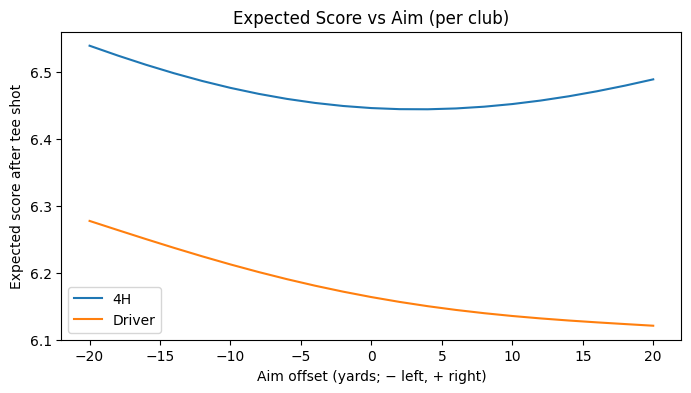

In [2]:
# ================== Golf Tee-Club Decision (Driver vs 4H) — Colab One-Cell (L/R + OB half-plane fixed) ==================
# Requirements & setup
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

# ---- Imports
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import Point, LineString, GeometryCollection
from shapely.ops import unary_union
import shapely
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot

# ===================== USER CONFIG =====================
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"   # for initial centering/OSM fetch
INITIAL_CENTER = (55.8068, -4.0760)                                 # fallback map center (lat, lon)
CRS_METERS = "EPSG:3857"
yd2m = 0.9144
m2yd = 1/yd2m

# Your dispersion (centered, yards). Tweak these to your real numbers.
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":28.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # aim left(−) to right(+)

# If FAIRWAY drawn as polyline, buffer to this total width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Sampling/config knobs (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
FW_BUFFER_CONNECT_M = 2.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0

# Landing-window (only integrate where the ball can realistically stop)
SIGMA_MULT          = 2.5
MIN_WINDOW_YDS      = 25.0

# Strokes-to-hole model settings (lightweight)
SKILL_ADJ = 0.6
OB_TAX       = 1.6
PENALTY_TAX  = 1.0
WATER_TAX    = 1.0

# ---------------- OSM helpers
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_fairway_union(G: gpd.GeoDataFrame):
    fw = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
    if not len(fw): return None
    U = unary_union(fw)
    U = shapely.buffer(U, FW_BUFFER_CONNECT_M)
    U = shapely.buffer(U, -FW_BUFFER_CONNECT_M)
    return U

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints_along_fairway(tee, green, fw_poly,
                                  step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                                  corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    # Tangent and RIGHT-hand normal (so +y = right of play)
    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids = []; last_mid_xy = None

    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last_mid_xy is not None:
                dx, dy = mid_xy[0]-last_mid_xy[0], mid_xy[1]-last_mid_xy[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*n[0] + dy*n[1])
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last_mid_xy[0] + par*t[0] + nor*n[0],
                          last_mid_xy[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last_mid_xy = mid_xy

    # smooth midpoints
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids:
        mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None,
                   ob_line=None, ob_side="right", step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        return v/(n+1e-12)

    def carve(cross, geom, label, spans):
        if geom is None or getattr(geom,"is_empty",True): return spans
        inter=cross.intersection(geom); segs=_extract_lines(inter)
        if not segs:
            inter2=cross.intersection(shapely.buffer(geom, 0.30))
            segs=_extract_lines(inter2)
            if not segs: return spans
        out=[]
        for m0,m1,lab in spans:
            cursor=m0; cuts=[]
            for seg in segs:
                a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                lo,hi=sorted([cross.project(a), cross.project(b)])
                lo,hi=max(lo,m0),min(hi,m1)
                if hi>lo: cuts.append((lo,hi))
            if not cuts: out.append((m0,m1,lab)); continue
            for lo,hi in sorted(cuts):
                if lo>cursor: out.append((cursor,lo,lab))
                out.append((lo,hi,label)); cursor=hi
            if cursor<m1: out.append((cursor,m1,lab))
        return out

    def apply_ob_halfplane(cross, spans, ob_line, side):
        if ob_line is None or getattr(ob_line,"is_empty",True): return spans
        inter = cross.intersection(ob_line)
        m_hit = None
        # Find a single intersection coordinate along the cross (0..2*half)
        if inter.is_empty:
            inter = cross.intersection(shapely.buffer(ob_line, 0.15))  # small buffer to be robust
        if inter.is_empty:
            return spans
        if inter.geom_type == "Point":
            m_hit = cross.project(inter)
        elif inter.geom_type == "MultiPoint":
            m_candidates = [cross.project(p) for p in inter.geoms]
            # choose the one closest to the cross centre
            m_hit = sorted(m_candidates, key=lambda v: abs(v - half))[0]
        elif inter.geom_type in ("LineString","MultiLineString"):
            # If colinear or overlapping weirdly, skip (rare)
            return spans
        if m_hit is None: return spans

        out=[]
        for m0,m1,lab in spans:
            if side == "right":
                # everything to the RIGHT of the OB line becomes OB
                left_hi = min(m1, m_hit)
                right_lo = max(m0, m_hit)
                if m0 < left_hi: out.append((m0, left_hi, lab))
                if right_lo < m1: out.append((right_lo, m1, "ob"))
            else:  # left side is OB
                left_hi = min(m1, m_hit)
                right_lo = max(m0, m_hit)
                if m0 < left_hi: out.append((m0, left_hi, "ob"))
                if right_lo < m1: out.append((right_lo, m1, lab))
        return out

    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s)
        d=tangent(centerline,s)
        # RIGHT-hand normal: +y = right of play
        n=np.array([d[1], -d[0]], float)

        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]   # background = rough

        # carve overlays (OB applied LAST so it dominates)
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)
        spans = apply_ob_halfplane(cross, spans, ob_line, ob_side)

        # merge touching segments, emit as y0,y1 in local cross axis (−half → +half; + is RIGHT)
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# ---- Gaussian helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

# ---- Strokes-to-hole curve (approximate)
FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)

def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    x = FW_ANCHORS[:,0]; y = FW_ANCHORS[:,1]
    fw = np.interp(d, x, y)
    if lie == "fairway":
        delta = 0.0
    elif lie == "rough":
        delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":
        delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":
        delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:
        delta = 0.0
    return fw + delta + skill_adj

def penalty_tax(label: str) -> float:
    if label == "ob": return OB_TAX
    if label == "water": return WATER_TAX
    if label == "penalty": return PENALTY_TAX
    return 0.0

# ---- Probability + Expected score
LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def fairway_width_at_station(sections, s):
    if s not in sections: return 0.0
    return sum(max(0.0, y1 - y0) for (y0,y1,lab) in sections[s] if lab=="fairway")

def build_frame_fields(centerline):
    """Precompute frames so +y is RIGHT of play."""
    L = centerline.length
    stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
    def tangent(line, s, eps=0.5):
        s0=max(0,s-eps); s1=min(line.length,s+eps)
        p0=line.interpolate(s0); p1=line.interpolate(s1)
        v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
        t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)
        return t, nvec
    frames={}
    for s in stations:
        t,n = tangent(centerline, s)
        p = centerline.interpolate(s)
        frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
    return frames, stations

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = aim RIGHT
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations) == 0: use_stations = stations

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    # For diagnostics
    s_peak = float(mu_s)
    s_near = float(use_stations[np.argmin((use_stations - mu_s)**2)]) if len(use_stations) else float(mu_s)

    for s in use_stations:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, tvec, nvec = frames[s]

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue

            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base_score = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base_score += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base_score

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    # Diagnostics: fairway width near peak
    fw_w_m = fairway_width_at_station(sections, round(s_near,1))
    diag = {
        "window_min_yds": s_min*m2yd,
        "window_max_yds": s_max*m2yd,
        "s_peak_yds": s_peak*m2yd,
        "fw_width_yds_at_peak": fw_w_m*m2yd
    }
    return out_pct, exp_score, diag

# ---------------- Interactive UI
print("Fetching OSM (for optional overlays/centering)…")
try:
    G_osm = load_golf_features(COURSE_QUERY)
except Exception:
    G_osm = gpd.GeoDataFrame(geometry=[], crs="EPSG:4326").to_crs(CRS_METERS)

fw_osm = build_fairway_union(G_osm) if not G_osm.empty else None
bunkers_osm = unary_union(G_osm[(G_osm.get("golf")=="bunker") & (G_osm.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if not G_osm.empty else None
water_osm   = unary_union(G_osm[(G_osm.get("natural")=="water") & (G_osm.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if not G_osm.empty else None

# Map
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw as:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
display(label_picker, ob_side_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={},
)
m.add_control(dc)

from shapely.geometry import shape as shp_shape

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl   = label_picker.value
    gtype = geo_json["geometry"]["type"]

    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ Fairway line must be a LINE. Ignored."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"):
            print("⚠️ Fairway polygon must be a POLYGON. Ignored."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"):
            print("⚠️ OB must be a LINE. Ignored."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return

    if gtype not in ("Polygon","MultiPolygon"):
        print(f"⚠️ {lbl} must be a POLYGON. Ignored."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

# Buttons + outputs
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a):
    return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks total).")
            return

        # Convert clicks to projected Points (metres)
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green_xy = np.array([green.x, green.y], float)

        # Re-center the map
        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16

        def _to_m(geom):
            return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # ---- Build FAIRWAY from user polygon and/or line (buffer), union with OSM if present
        fw_use = fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([_to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([_to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        # ---- Other layers (union user + OSM)
        bunkers_use = bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([_to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use = None
        if user_polys["penalty"]:
            pen_user = unary_union([_to_m(g) for g in user_polys["penalty"]])
            penalty_use = pen_user
            print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")
        water_use = water_osm
        if user_polys["water"]:
            wat_user = unary_union([_to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = None
        if user_polys["recovery"]:
            rec_user = unary_union([_to_m(g) for g in user_polys["recovery"]])
            recovery_use = rec_user
            print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_line = None
        if user_lines["ob"]:
            ob_line = unary_union([_to_m(g) for g in user_lines["ob"]])
            print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (half-plane, side='{ob_side_picker.value}')")

        # ---- Centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints_along_fairway(
            tee, green, fw_use if fw_use is not None else shapely.Polygon(),
            step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
            corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW
        )
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # ---- Clip everything to this hole corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # Fallback fairway if none
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m around centreline.")

        # ---- Visual centreline overlay
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # ---- Cross-sections (OB applied as half-plane on chosen side)
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_line=ob_line, ob_side=ob_side_picker.value)

        if df_long is None or df_long.empty:
            print("⚠️ No intersections produced by your shapes. Using rough-only synthetic sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # ---- Frames for distance-to-green
        frames, stations_full = build_frame_fields(centerline)

        # ---- Compute probabilities & expected score for each club; aim sweep to minimize score
        rows_summary = []
        for name, cfg0 in CLUBS.items():
            best = None
            for a in AIM_SWEEP_YDS:
                cfg = dict(cfg0); cfg["aim_offset_yds"] = float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                # optional: bias away from OB a touch if tied
                key = (exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best = {"aim_yds": a, "pct": pct, "exp_score": exp_score, "diag": diag, "key": key}
            pct = best["pct"]; d = best["diag"]
            # sanity warning if fairway coverage is tiny at your peak
            if d["fw_width_yds_at_peak"] < 3.0:
                print(f"⚠️ {name}: Fairway width near {d['s_peak_yds']:.0f} yds is ~{d['fw_width_yds_at_peak']:.1f} yds — "
                      f'your fairway polygon may not extend to your landing window ('
                      f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds).")
            rows_summary.append({
                "Club": name, "Best aim (yds)": best["aim_yds"],
                "Exp score": round(best["exp_score"], 3),
                "Fairway%": pct["fairway"], "Rough%": pct["rough"], "Bunker%": pct["bunker"],
                "Recovery%": pct["recovery"], "Penalty%": pct["penalty"], "Water%": pct["water"], "OB%": pct["ob"],
                "Window yds": f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}",
                "FW @peak (yds)": round(d["fw_width_yds_at_peak"],1)
            })

        df_summary = pd.DataFrame(rows_summary).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds","FW @peak (yds)"]])

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']}  | aim {best_row['Best aim (yds)']:+.0f} yds ({lr(best_row['Best aim (yds)'])})"
              f"  | expected score ≈ {best_row['Exp score']:.3f}")

        # ---- Simple viz: expected score vs aim for both clubs
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg = dict(cfg0); cfg["aim_offset_yds"] = float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)")
        plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim (per club)")
        plt.legend(); plt.show()

run_btn.on_click(process)

print("\nSteps:")
print("  1) Click TEE, then click GREEN on the map (2 markers).")
print("  2) Use the dropdown to draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose which side of your OB line is out-of-bounds (toggle above).")
print("  4) Press 'Process Tee & Green'.  Positive aim = RIGHT of centreline.")
print("\nNotes:")
print("  • If Driver Fairway% looks implausibly low, check the table column 'FW @peak (yds)'.")
print("    If it’s ~0–3 yds, your fairway polygon probably stops before your driver window.")
print("  • Adjust your dispersion (sigma_lat_yds, sigma_long_yds, mean_stop_yds) to your real data.")


In [3]:
# ================== Tee Club Decision — Geometry-fixed, Primary FW only, Robust OB, σ tweak ==================
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

import numpy as np, pandas as pd, geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, GeometryCollection, Polygon
from shapely.ops import unary_union, split
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot

# ---------------- CONFIG ----------------
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
INITIAL_CENTER = (55.8068, -4.0760)
CRS_METERS = "EPSG:3857"
yd2m = 0.9144; m2yd = 1/yd2m

# Use only user-drawn shapes by default (prevents OSM inflating widths)
USE_OSM_FAIRWAY   = False
USE_OSM_BUNKERS   = False
USE_OSM_WATER     = False

# Your dispersions (yards). Driver lateral σ set to 40 per your note.
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":40.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # − = left, + = right

# If fairway drawn as line, buffer to this TOTAL width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Geometry sampling (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0

# Landing window (metres)
SIGMA_MULT       = 2.5
MIN_WINDOW_YDS   = 25.0

# Strokes-to-hole (approx)
SKILL_ADJ = 0.6
OB_TAX       = 2.2   # bumped to better reflect stroke & distance pain
PENALTY_TAX  = 1.0
WATER_TAX    = 1.0

PRIMARY_FAIRWAY_ONLY = True  # <<< crucial: only count the fairway band nearest the centreline

# ---------------- OSM helpers ----------------
ox.settings.use_cache = True
ox.settings.log_console = False

def load_golf_features(course_query: str) -> gpd.GeoDataFrame:
    try:
        area = ox.geocoder.geocode_to_gdf(course_query)
    except Exception:
        area = getattr(ox, "geocode_to_gdf")(course_query)
    if area.crs is None: area = area.set_crs(4326)
    poly_wgs84 = area.to_crs(4326).geometry.iloc[0]
    tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
    try:
        G = ox.features.features_from_polygon(poly_wgs84, tags)
    except Exception:
        G = getattr(ox, "features_from_polygon")(poly_wgs84, tags)
    if G.crs is None: G = G.set_crs(4326)
    return G.to_crs(CRS_METERS).reset_index(drop=True)

def build_osm_layers():
    try:
        G = load_golf_features(COURSE_QUERY)
    except Exception:
        return None, None, None
    fw = None
    if USE_OSM_FAIRWAY:
        polys = G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
        fw = unary_union(polys) if len(polys) else None
    bun = None
    if USE_OSM_BUNKERS:
        polys = G[(G.get("golf")=="bunker") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
        bun = unary_union(polys) if len(polys) else None
    wat = None
    if USE_OSM_WATER:
        polys = G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry
        wat = unary_union(polys) if len(polys) else None
    return fw, bun, wat

fw_osm, bunkers_osm, water_osm = build_osm_layers()

# ---------------- Geometry utils ----------------
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints(tee, green, fw_poly,
                    step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                    corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    # Tangent and RIGHT-hand normal (+y = right)
    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids=[]; last=None
    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs = _extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs = _extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)

            if last is not None:
                dx, dy = mid_xy[0]-last[0], mid_xy[1]-last[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*(t[1])*-1 + dy*(t[0]))  # projection onto n
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last[0] + par*t[0] + nor*n[0], last[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last = mid_xy

    # smooth
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def tangent_normal(centerline, s, eps=0.5):
    s0=max(0,s-eps); s1=min(centerline.length,s+eps)
    p0=centerline.interpolate(s0); p1=centerline.interpolate(s1)
    v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
    t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)   # right-hand normal
    return t, nvec

def build_frames(centerline):
    L = centerline.length
    stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
    frames={}
    for s in stations:
        t,n = tangent_normal(centerline, s)
        p = centerline.interpolate(s)
        frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
    return frames, stations

# Make OB a true half-plane: split the corridor polygon by the OB line
def ob_halfplane_polygon(corridor_clip: Polygon, ob_line: LineString, centerline: LineString, side: str):
    if ob_line is None or getattr(ob_line, "is_empty", True): return None
    try:
        parts = split(corridor_clip, ob_line)
    except Exception:
        # Try splitting with a small buffer if geometries are messy
        try:
            parts = split(corridor_clip, shapely.buffer(ob_line, 0.05))
        except Exception:
            return None
    if not parts or len(parts.geoms) < 2: return None

    # Decide which part is "right of play" using a test point slightly to the RIGHT of the mid-station
    s_mid = centerline.length*0.5
    p_mid = centerline.interpolate(s_mid)
    _, n = tangent_normal(centerline, s_mid)
    test_pt = Point(p_mid.x + 3.0*n[0], p_mid.y + 3.0*n[1])

    right_poly, left_poly = None, None
    for piece in parts.geoms:
        if piece.contains(test_pt): right_poly = piece
        else: left_poly = piece
    if side=="right": return right_poly
    return left_poly

# Cross-sections (carve polygons, +y=right)
def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob_poly=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    rows=[]; L=centerline.length
    stations=np.arange(0.0, L+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s)
        _,n=tangent_normal(centerline,s)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        # start with rough band
        spans=[(0,2*half,"rough")]

        def carve(cross, geom, label, spans):
            if geom is None or getattr(geom,"is_empty",True): return spans
            inter=cross.intersection(geom); segs=_extract_lines(inter)
            if not segs:
                inter2=cross.intersection(shapely.buffer(geom, 0.30))
                segs=_extract_lines(inter2)
                if not segs: return spans
            out=[]
            for m0,m1,lab in spans:
                cursor=m0; cuts=[]
                for seg in segs:
                    a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                    lo,hi=sorted([cross.project(a), cross.project(b)])
                    lo,hi=max(lo,m0),min(hi,m1)
                    if hi>lo: cuts.append((lo,hi))
                if not cuts: out.append((m0,m1,lab)); continue
                for lo,hi in sorted(cuts):
                    if lo>cursor: out.append((cursor,lo,lab))
                    out.append((lo,hi,label)); cursor=hi
                if cursor<m1: out.append((cursor,m1,lab))
            return out

        # Order: hazards, fairway, recovery; OB last so it dominates
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)
        spans = carve(cross, ob_poly, "ob",      spans)

        # merge and convert to (y0,y1,label)
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(s,1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# --------- Normal helpers ---------
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

# Strokes-to-hole (approx Broadie shape + lie deltas + skill)
FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)

def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    x = FW_ANCHORS[:,0]; y = FW_ANCHORS[:,1]
    fw = np.interp(d, x, y)
    if lie == "fairway":
        delta = 0.0
    elif lie == "rough":
        delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":
        delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":
        delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:
        delta = 0.0
    return fw + delta + skill_adj

def penalty_tax(label: str) -> float:
    if label == "ob": return OB_TAX
    if label == "water": return WATER_TAX
    if label == "penalty": return PENALTY_TAX
    return 0.0

LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def primary_fairway_segment(bands):
    fws = [(y0,y1) for (y0,y1,lab) in bands if lab=="fairway"]
    if not fws: return None
    def dist_to_zero(seg):
        y0,y1=seg
        if y0<=0<=y1: return 0.0
        return min(abs(y0),abs(y1),abs(0.5*(y0+y1)))
    return min(fws, key=dist_to_zero)

def fw_width_primary(sections, s):
    spans = sections.get(s, [])
    seg = primary_fairway_segment(spans)
    return 0.0 if seg is None else max(0.0, seg[1]-seg[0])

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = right
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations)==0: use_stations = stations

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    s_peak = float(mu_s)
    s_near = float(use_stations[np.argmin((use_stations - mu_s)**2)]) if len(use_stations) else float(mu_s)

    for s in use_stations:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, tvec, nvec = frames[s]

        # Keep only the primary fairway band (nearest to centreline)
        if PRIMARY_FAIRWAY_ONLY:
            seg = primary_fairway_segment(bands)
            filtered=[]
            for (y0,y1,lab) in bands:
                if lab!="fairway": filtered.append((y0,y1,lab))
            if seg is not None:
                filtered.append((seg[0],seg[1],"fairway"))
            bands = filtered

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue
            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    fw_w_m = fw_width_primary(sections, round(s_near,1))
    diag = {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd,
            "s_peak_yds": s_peak*m2yd, "fw_width_yds_at_peak": fw_w_m*m2yd}
    return out_pct, exp_score, diag

# ---------------- UI ----------------
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))
clicks=[]

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon (non-water)","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
display(label_picker, ob_side_picker)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}
dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={}
)
m.add_control(dc)

from shapely.geometry import shape as shp_shape

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl = label_picker.value; gtype = geo_json["geometry"]["type"]
    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ Fairway line must be LINE."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"): print("⚠️ Fairway polygon must be POLYGON."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ OB must be LINE."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return
    if gtype not in ("Polygon","MultiPolygon"): print(f"⚠️ {lbl} must be POLYGON."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def on_click(**kwargs):
    if kwargs.get("type")=="click":
        lat, lon = kwargs["coordinates"]
        if len(clicks) < 2: clicks.append((lat, lon))
        else: clicks[1] = (lat, lon)
        m.add_layer(Marker(location=(lat, lon)))
        print(f"Clicked: {lat:.6f}, {lon:.6f}  (#{len(clicks)})")
m.on_interaction(on_click)
display(m)

run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a): return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if len(clicks) < 2:
            print("Please click the TEE then the GREEN (2 clicks)."); return

        # Project clicks
        tee_lat, tee_lon = clicks[0]; grn_lat, grn_lon = clicks[1]
        tee   = gpd.GeoSeries([Point(tee_lon, tee_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(grn_lon, grn_lat)], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green_xy = np.array([green.x, green.y], float)

        m.center = ((tee_lat + grn_lat)/2.0, (tee_lon + grn_lon)/2.0); m.zoom = 16
        to_m = lambda geom: gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Build fairway from USER shapes only (no OSM union unless enabled)
        fw_use = None if not USE_OSM_FAIRWAY else fw_osm
        if user_polys["fairway"]:
            fw_poly = unary_union([to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        bunkers_use = None if not USE_OSM_BUNKERS else bunkers_osm
        if user_polys["bunker"]:
            bun_user = unary_union([to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")

        penalty_use = unary_union([to_m(g) for g in user_polys["penalty"]]) if user_polys["penalty"] else None
        if penalty_use is not None: print(f"Using user-drawn PENALTY polygon(s): {len(user_polys['penalty'])}")

        water_use = None if not USE_OSM_WATER else water_osm
        if user_polys["water"]:
            wat_user = unary_union([to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")

        recovery_use = unary_union([to_m(g) for g in user_polys["recovery"]]) if user_polys["recovery"] else None
        if recovery_use is not None: print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_line = unary_union([to_m(g) for g in user_lines["ob"]]) if user_lines["ob"] else None
        if ob_line is not None: print(f"Using user-drawn OB line(s): {len(user_lines['ob'])}")

        # Centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints(tee, green, fw_use if fw_use is not None else shapely.Polygon())
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # Clip corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # OB half-plane polygon (robust)
        ob_poly = ob_halfplane_polygon(corridor_clip, ob_line, centerline, ob_side_picker.value) if ob_line is not None else None

        # Fallback fairway
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m.")

        # Draw centreline only (no folium world map)
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # Sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_poly=ob_poly)
        if df_long is None or df_long.empty:
            print("⚠️ No intersections; synthesizing rough-only sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # Frames
        frames, _ = build_frames(centerline)

        # Compute
        rows=[]
        sanity_lines=[]
        for name, cfg0 in CLUBS.items():
            best=None
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                key=(exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best={"aim_yds":a,"pct":pct,"exp_score":exp_score,"diag":diag,"key":key}
            pct=best["pct"]; d=best["diag"]

            # Sanity: 1-D normal vs measured FW @peak
            fw_yds=d["fw_width_yds_at_peak"]; sig=cfg0["sigma_lat_yds"]
            if fw_yds>0 and sig>0:
                half=fw_yds/2.0; p_1d = 100.0*(_Phi(half/sig)-_Phi(-half/sig))
                sanity_lines.append(f"{name} sanity @peak: FW≈{fw_yds:.1f}yd, σ={sig:.1f}yd → 1D fairway≈{p_1d:.1f}%  (geom: {pct['fairway']:.1f}%)")

            rows.append({
                "Club":name, "Best aim (yds)":best["aim_yds"],
                "Exp score":round(best["exp_score"],3),
                "Fairway%":pct["fairway"], "Rough%":pct["rough"], "Bunker%":pct["bunker"],
                "Recovery%":pct["recovery"], "Penalty%":pct["penalty"], "Water%":pct["water"], "OB%":pct["ob"],
                "Window yds":f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}",
                "FW @peak (yds)":round(d["fw_width_yds_at_peak"],1)
            })

        df_summary = pd.DataFrame(rows).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds","FW @peak (yds)"]])

        # Show sanity lines
        for s in sanity_lines: print("•", s)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']} | aim {best_row['Best aim (yds)']:+.0f} yds ({lr(best_row['Best aim (yds)'])})"
              f" | expected score ≈ {best_row['Exp score']:.3f}")

        # Plot expected score vs aim
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim"); plt.legend(); plt.show()

run_btn.on_click(process)

print("\nSteps:")
print("  1) Click TEE, then GREEN.")
print("  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose which side of your OB line is out-of-bounds.")
print("Notes:")
print("  • Only the primary fairway band nearest the centreline is counted, preventing extra fairways inflating FW%.")
print("  • OSM fairways/bunkers/water are OFF by default to avoid geometry contamination.")
print("  • Driver σ_lat set to 40 yds per your comment; tweak CLUBS if needed.")


Dropdown(description='Draw:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_line…

ToggleButtons(options=(('OB side: Right of line', 'right'), ('OB side: Left of line', 'left')), value='right')

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()


Steps:
  1) Click TEE, then GREEN.
  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.
  3) Choose which side of your OB line is out-of-bounds.
Notes:
  • Only the primary fairway band nearest the centreline is counted, preventing extra fairways inflating FW%.
  • OSM fairways/bunkers/water are OFF by default to avoid geometry contamination.
  • Driver σ_lat set to 40 yds per your comment; tweak CLUBS if needed.
Clicked: 55.805840, -4.074125  (#1)
Clicked: 55.808095, -4.075874  (#2)
Clicked: 55.807992, -4.075992  (#2)
Clicked: 55.808028, -4.075638  (#2)
Clicked: 55.807480, -4.075370  (#2)
Clicked: 55.807027, -4.074994  (#2)
Clicked: 55.806816, -4.074630  (#2)
Clicked: 55.806509, -4.074490  (#2)
Clicked: 55.806244, -4.074275  (#2)
Clicked: 55.806129, -4.074243  (#2)
Clicked: 55.806123, -4.074458  (#2)
Clicked: 55.806406, -4.074780  (#2)
Clicked: 55.806726, -4.075263  (#2)
Clicked: 55.807214, -4.075735  (#2)
Clicked: 55.807329, -4.075606  (#2)
Clicked:

Using user-drawn FAIRWAY polygon(s): 1
Using user-drawn BUNKER polygon(s): 3
Using user-drawn RECOVERY polygon(s): 1
Using user-drawn OB line(s): 1 (half-plane)
Building centreline in tee→green corridor…
Chord ≈ 492.8 m  |  Centreline ≈ 1651.9 m
Sampling cross-sections…
Cross-section stations: 1652 (step ≈ 1.0 m)

=== Expected Score Summary (lower is better) ===


,Club,Best aim (yds),Exp score,Fairway%,Rough%,Bunker%,Recovery%,Penalty%,Water%,OB%,Window yds,FW @peak (yds)
1,Driver,-20,6.62,0.0,100.0,0.0,0.0,0.0,0.0,0.0,192–242,0.0
0,4H,-20,6.80,0.0,100.0,0.0,0.0,0.0,0.0,0.0,157–207,0.0



👉 Recommended: Driver | aim -20 yds (left) | expected score ≈ 6.620


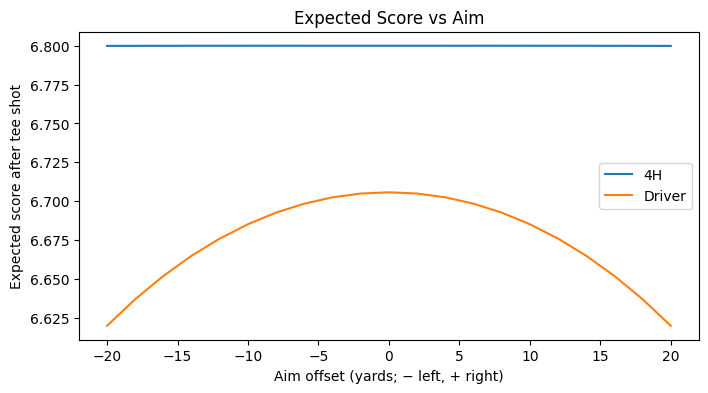

In [4]:
# =============== Tee Club Decision — SAFE Tee/Green Picking + Robust OB + Primary Fairway Only ===============
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, GeometryCollection, Polygon, shape as shp_shape
from shapely.ops import unary_union, split
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot

# ---------------- CONFIG ----------------
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
INITIAL_CENTER = (55.8068, -4.0760)           # starting map view
CRS_METERS = "EPSG:3857"
yd2m = 0.9144; m2yd = 1/yd2m

# Use only user-drawn geometry to avoid width inflation
USE_OSM_FAIRWAY = False
USE_OSM_BUNKERS = False
USE_OSM_WATER   = False

# Dispersion (yards). Set to YOUR stats. (Driver σ_lat = 40 per your note)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":40.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # − = left, + = right

# If fairway is drawn as polyline, buffer to TOTAL width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Sampling / geometry (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0

# Landing window (metres)
SIGMA_MULT       = 2.5
MIN_WINDOW_YDS   = 25.0

# Strokes-to-hole (lite)
SKILL_ADJ = 0.6
OB_TAX       = 2.2
PENALTY_TAX  = 1.0
WATER_TAX    = 1.0

PRIMARY_FAIRWAY_ONLY = True  # only the fairway band nearest the centreline

# ---------------- OSM (optional, default off) ----------------
ox.settings.use_cache = True
ox.settings.log_console = False

def load_osm_layers():
    try:
        area = ox.geocoder.geocode_to_gdf(COURSE_QUERY)
        if area.crs is None: area = area.set_crs(4326)
        poly = area.to_crs(4326).geometry.iloc[0]
        tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
        G = ox.features.features_from_polygon(poly, tags)
        if G.crs is None: G = G.set_crs(4326)
        G = G.to_crs(CRS_METERS).reset_index(drop=True)
    except Exception:
        return None, None, None
    fw = unary_union(G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_FAIRWAY else None
    bun = unary_union(G[(G.get("golf")=="bunker")  & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_BUNKERS else None
    wat = unary_union(G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_WATER else None
    return fw, bun, wat

fw_osm, bunkers_osm, water_osm = load_osm_layers()

# ---------------- Geometry helpers ----------------
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints(tee, green, fw_poly,
                    step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                    corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    # Tangent and RIGHT-hand normal (+y = right of play)
    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids=[]; last=None
    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs=_extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs=_extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)
            if last is not None:
                dx, dy = mid_xy[0]-last[0], mid_xy[1]-last[1]
                par = (dx*t[0] + dy*t[1]); nor = (dx*(t[1])*-1 + dy*(t[0]))
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last[0] + par*t[0] + nor*n[0], last[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last = mid_xy

    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def tangent_normal(centerline, s, eps=0.5):
    s0=max(0,s-eps); s1=min(centerline.length,s+eps)
    p0=centerline.interpolate(s0); p1=centerline.interpolate(s1)
    v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
    t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)   # right-hand normal
    return t, nvec

def build_frames(centerline):
    L = centerline.length
    stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
    frames={}
    for s in stations:
        t,n = tangent_normal(centerline, s)
        p = centerline.interpolate(s)
        frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
    return frames, stations

# Make OB a true half-plane: split corridor polygon by OB line
def ob_halfplane_polygon(corridor_clip: Polygon, ob_line: LineString, centerline: LineString, side: str):
    if ob_line is None or getattr(ob_line, "is_empty", True): return None
    try:
        parts = split(corridor_clip, ob_line)
    except Exception:
        try:
            parts = split(corridor_clip, shapely.buffer(ob_line, 0.05))
        except Exception:
            return None
    if not parts or len(parts.geoms) < 2: return None
    # Decide which piece is "right of play"
    s_mid = centerline.length*0.5
    p_mid = centerline.interpolate(s_mid)
    _, n = tangent_normal(centerline, s_mid)
    test_pt = Point(p_mid.x + 3.0*n[0], p_mid.y + 3.0*n[1])
    right_poly, left_poly = None, None
    for piece in parts.geoms:
        if piece.contains(test_pt): right_poly = piece
        else: left_poly = piece
    return right_poly if side=="right" else left_poly

# Cross-sections with +y = right
def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob_poly=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    rows=[]; stations=np.arange(0.0, centerline.length+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); _,n=tangent_normal(centerline,s)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]
        def carve(cross, geom, label, spans):
            if geom is None or getattr(geom,"is_empty",True): return spans
            inter=cross.intersection(geom); segs=_extract_lines(inter)
            if not segs:
                inter2=cross.intersection(shapely.buffer(geom, 0.30))
                segs=_extract_lines(inter2)
                if not segs: return spans
            out=[]
            for m0,m1,lab in spans:
                cursor=m0; cuts=[]
                for seg in segs:
                    a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                    lo,hi=sorted([cross.project(a), cross.project(b)])
                    lo,hi=max(lo,m0),min(hi,m1)
                    if hi>lo: cuts.append((lo,hi))
                if not cuts: out.append((m0,m1,lab)); continue
                for lo,hi in sorted(cuts):
                    if lo>cursor: out.append((cursor,lo,lab))
                    out.append((lo,hi,label)); cursor=hi
                if cursor<m1: out.append((cursor,m1,lab))
            return out
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)
        spans = carve(cross, ob_poly, "ob",      spans)
        # merge and emit
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(float(s),1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# -------- Normal helpers --------
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

# Strokes-to-hole (approx)
FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)
def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    fw = np.interp(d, FW_ANCHORS[:,0], FW_ANCHORS[:,1])
    if lie == "fairway":   delta = 0.0
    elif lie == "rough":   delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":  delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:                  delta = 0.0
    return fw + delta + skill_adj
def penalty_tax(label: str) -> float:
    return OB_TAX if label=="ob" else (WATER_TAX if label=="water" else (PENALTY_TAX if label=="penalty" else 0.0))

LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def primary_fairway_segment(bands):
    fws = [(y0,y1) for (y0,y1,lab) in bands if lab=="fairway"]
    if not fws: return None
    def dist_to_zero(seg):
        y0,y1=seg
        if y0<=0<=y1: return 0.0
        return min(abs(y0),abs(y1),abs(0.5*(y0+y1)))
    return min(fws, key=dist_to_zero)

def fw_width_primary(sections, s):
    spans = sections.get(s, [])
    seg = primary_fairway_segment(spans)
    return 0.0 if seg is None else max(0.0, seg[1]-seg[0])

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = right
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    use = stations[(stations >= max(0.0, s_min)) & (stations <= s_max)]
    if len(use)==0: use = stations

    total = {k: 0.0 for k in LABELS}
    total_w = 0.0
    exp_score_accum = 0.0

    s_peak = float(mu_s)
    s_near = float(use[np.argmin((use - mu_s)**2)]) if len(use) else float(mu_s)

    for s in use:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, _, nvec = frames[s]

        if PRIMARY_FAIRWAY_ONLY:
            seg = primary_fairway_segment(bands)
            filtered=[(y0,y1,lab) for (y0,y1,lab) in bands if lab!="fairway"]
            if seg is not None: filtered.append((seg[0],seg[1],"fairway"))
            bands = filtered

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue
            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    fw_w_m = fw_width_primary(sections, round(s_near,1))
    diag = {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd,
            "s_peak_yds": s_peak*m2yd, "fw_width_yds_at_peak": fw_w_m*m2yd}
    return out_pct, exp_score, diag

# ---------------- UI (SAFE tee/green pick) ----------------
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
pick_lbl = widgets.HTML("<b>Click “Pick Tee” / “Pick Green”, then click the map once.</b>")
btn_pick_tee   = widgets.Button(description="Pick Tee", icon="map-marker")
btn_pick_green = widgets.Button(description="Pick Green", icon="flag-checkered")
btn_clear_tg   = widgets.Button(description="Clear Tee/Green", icon="trash")
display(label_picker, ob_side_picker, widgets.HBox([btn_pick_tee, btn_pick_green, btn_clear_tg]), pick_lbl)

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={}
)
m.add_control(dc)

tee_ll = None; green_ll = None
tee_marker = None; green_marker = None
click_mode = None

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl = label_picker.value; gtype = geo_json["geometry"]["type"]
    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ Fairway line must be LINE."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"): print("⚠️ Fairway polygon must be POLYGON."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ OB must be LINE."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return
    if gtype not in ("Polygon","MultiPolygon"): print(f"⚠️ {lbl} must be POLYGON."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def set_marker(kind, lat, lon):
    global tee_ll, green_ll, tee_marker, green_marker
    if kind=="tee":
        tee_ll = (lat, lon)
        if tee_marker: m.remove_layer(tee_marker)
        tee_marker = Marker(location=tee_ll)
        m.add_layer(tee_marker)
        print(f"TEE set: {lat:.6f}, {lon:.6f}")
    else:
        green_ll = (lat, lon)
        if green_marker: m.remove_layer(green_marker)
        green_marker = Marker(location=green_ll)
        m.add_layer(green_marker)
        print(f"GREEN set: {lat:.6f}, {lon:.6f}")

def on_map_click(**kwargs):
    global click_mode
    if kwargs.get("type")=="click" and click_mode in ("tee","green"):
        lat, lon = kwargs["coordinates"]
        set_marker(click_mode, lat, lon)
        click_mode = None
m.on_interaction(on_map_click)
display(m)

def start_pick(kind):
    global click_mode
    click_mode = kind
    pick_lbl.value = f"<b>Picking {kind.upper()}:</b> click once on the map…"
btn_pick_tee.on_click(lambda b: start_pick("tee"))
btn_pick_green.on_click(lambda b: start_pick("green"))

def clear_tg(_):
    global tee_ll, green_ll, tee_marker, green_marker, click_mode
    if tee_marker: m.remove_layer(tee_marker)
    if green_marker: m.remove_layer(green_marker)
    tee_ll = green_ll = tee_marker = green_marker = None
    click_mode = None
    print("Cleared tee/green.")
btn_clear_tg.on_click(clear_tg)

# ---------------- Run & output ----------------
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a): return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if tee_ll is None or green_ll is None:
            print("Please set both TEE and GREEN (use the buttons above)."); return

        # Project to metres
        tee   = gpd.GeoSeries([Point(tee_ll[1],  tee_ll[0])],  crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(green_ll[1], green_ll[0])], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green_xy = np.array([green.x, green.y], float)

        # Recentre map
        m.center = ((tee_ll[0] + green_ll[0])/2.0, (tee_ll[1] + green_ll[1])/2.0); m.zoom = 16

        to_m = lambda geom: gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Fairway: use only what you drew unless OSM is enabled
        fw_use = fw_osm if USE_OSM_FAIRWAY else None
        if user_polys["fairway"]:
            fw_poly = unary_union([to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        bunkers_use  = (bunkers_osm if USE_OSM_BUNKERS else None)
        if user_polys["bunker"]:
            bun_user = unary_union([to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use  = unary_union([to_m(g) for g in user_polys["penalty"]])  if user_polys["penalty"]  else None
        water_use    = (water_osm if USE_OSM_WATER else None)
        if user_polys["water"]:
            wat_user = unary_union([to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = unary_union([to_m(g) for g in user_polys["recovery"]]) if user_polys["recovery"] else None
        if recovery_use is not None: print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_line = unary_union([to_m(g) for g in user_lines["ob"]]) if user_lines["ob"] else None
        if ob_line is not None: print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (half-plane)")

        # Centreline
        print("Building centreline in tee→green corridor…")
        centerline, chord_len = chord_midpoints(tee, green, fw_use if fw_use is not None else shapely.Polygon())
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m")

        # Clip everything to corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # OB polygon (half-plane inside the corridor)
        ob_poly = ob_halfplane_polygon(corridor_clip, ob_line, centerline, ob_side_picker.value) if ob_line is not None else None

        # Fallback fairway if none
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available; using fallback corridor ±{half_m:.1f} m.")

        # Draw centreline
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # Sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_poly=ob_poly)
        if df_long is None or df_long.empty:
            print("⚠️ No intersections; synthesizing rough-only sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # Frames
        frames, _ = build_frames(centerline)

        # Compute
        rows=[]; sanity=[]
        for name, cfg0 in CLUBS.items():
            best=None
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                key=(exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best={"aim_yds":a,"pct":pct,"exp_score":exp_score,"diag":diag,"key":key}
            pct=best["pct"]; d=best["diag"]

            # Sanity: 1D normal vs geometry at peak FW
            fw_yds=d["fw_width_yds_at_peak"]; sig=cfg0["sigma_lat_yds"]
            if fw_yds>0 and sig>0:
                half=fw_yds/2.0; p1d = 100.0*(_Phi(half/sig)-_Phi(-half/sig))
                sanity.append(f"{name} sanity @peak: FW≈{fw_yds:.1f}yd, σ={sig:.1f}yd → 1D fairway≈{p1d:.1f}%  (geom: {pct['fairway']:.1f}%)")

            rows.append({
                "Club":name, "Best aim (yds)":best["aim_yds"],
                "Exp score":round(best["exp_score"],3),
                "Fairway%":pct["fairway"], "Rough%":pct["rough"], "Bunker%":pct["bunker"],
                "Recovery%":pct["recovery"], "Penalty%":pct["penalty"], "Water%":pct["water"], "OB%":pct["ob"],
                "Window yds":f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}",
                "FW @peak (yds)":round(d["fw_width_yds_at_peak"],1)
            })

        df_summary = pd.DataFrame(rows).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds","FW @peak (yds)"]])

        for s in sanity: print("•", s)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']} | aim {best_row['Best aim (yds)']:+.0f} yds ({'right' if best_row['Best aim (yds)']>0 else ('left' if best_row['Best aim (yds)']<0 else 'center')})"
              f" | expected score ≈ {best_row['Exp score']:.3f}")

        # Plot expected score vs aim
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim"); plt.legend(); plt.show()

run_btn.on_click(process)

print("\nHow to use:")
print("  1) Click 'Pick Tee' then click the map. Click 'Pick Green' then click the map.")
print("     (Map clicks are IGNORED unless in pick mode — drawing won’t overwrite tee/green.)")
print("  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose which side of your OB line is out-of-bounds.")
print("  4) Press 'Process Tee & Green'.  Positive aim = RIGHT of centreline.")
print("Notes:")
print("  • Only the primary (nearest) fairway band counts, preventing extra fairways inflating FW%.")
print("  • OSM overlays are OFF by default to avoid geometry contamination.")
print("  • The output prints a 1-D normal sanity check vs geometry-derived fairway%.")


In [5]:
# ===== Tee Club Decision — Robust centreline fallback + primary fairway only + OB half-plane =====
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, GeometryCollection, Polygon, shape as shp_shape
from shapely.ops import unary_union, split
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot

# ---------------- CONFIG ----------------
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"
INITIAL_CENTER = (55.8068, -4.0760)
CRS_METERS = "EPSG:3857"
yd2m = 0.9144; m2yd = 1/yd2m

# Use only user-drawn geometry (avoids parallel-hole contamination)
USE_OSM_FAIRWAY = False
USE_OSM_BUNKERS = False
USE_OSM_WATER   = False

# Your dispersions (yards) — set to your stats
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":40.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},  # σ_lat=40 per your note
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # − = left, + = right

# If fairway drawn as LINE, buffer to TOTAL width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Geometry sampling (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0

# Landing window
SIGMA_MULT       = 2.5
MIN_WINDOW_YDS   = 25.0

# Strokes-to-hole (lite)
SKILL_ADJ = 0.6
OB_TAX       = 2.2
PENALTY_TAX  = 1.0
WATER_TAX    = 1.0

PRIMARY_FAIRWAY_ONLY = True

# ---------------- OSM (optional, default off) ----------------
ox.settings.use_cache = True
ox.settings.log_console = False

def load_osm_layers():
    try:
        area = ox.geocoder.geocode_to_gdf(COURSE_QUERY)
        if area.crs is None: area = area.set_crs(4326)
        poly = area.to_crs(4326).geometry.iloc[0]
        tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
        G = ox.features.features_from_polygon(poly, tags)
        if G.crs is None: G = G.set_crs(4326)
        G = G.to_crs(CRS_METERS).reset_index(drop=True)
    except Exception:
        return None, None, None
    fw = unary_union(G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_FAIRWAY else None
    bun = unary_union(G[(G.get("golf")=="bunker")  & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_BUNKERS else None
    wat = unary_union(G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_WATER else None
    return fw, bun, wat

fw_osm, bunkers_osm, water_osm = load_osm_layers()

# ---------------- Geometry helpers ----------------
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def chord_midpoints(tee, green, fw_poly,
                    step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                    corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    # Tangent and RIGHT-hand normal (+y = right of play)
    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids=[]; last=None
    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs=_extract_lines(inter)
            if not segs:
                inter2 = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs=_extract_lines(inter2)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)
            if last is not None:
                dx, dy = mid_xy[0]-last[0], mid_xy[1]-last[1]
                # project onto tangent/normal (RIGHT-hand normal)
                par = (dx*t[0] + dy*t[1])
                nor = (dx*(-t[1]) + dy*( t[0]))   # dot with n = [ t_y, -t_x ]
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last[0] + par*t[0] + nor*n[0],
                          last[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last = mid_xy

    # smooth
    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def tangent_normal(centerline, s, eps=0.5):
    s0=max(0,s-eps); s1=min(centerline.length,s+eps)
    p0=centerline.interpolate(s0); p1=centerline.interpolate(s1)
    v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
    t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)   # right-hand normal
    return t, nvec

def build_frames(centerline):
    L = centerline.length
    stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
    frames={}
    for s in stations:
        t,n = tangent_normal(centerline, s)
        p = centerline.interpolate(s)
        frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
    return frames, stations

# Fail-safe: if generated centreline looks insane, fall back to straight chord
def sane_centreline(centerline, chord, max_ratio=1.25):
    try:
        ratio = centerline.length / max(chord.length, 1e-6)
        if (ratio > max_ratio) or (not centerline.is_simple):
            return chord
    except Exception:
        return chord
    return centerline

# OB half-plane polygon (split corridor by OB line)
def ob_halfplane_polygon(corridor_clip: Polygon, ob_line: LineString, centerline: LineString, side: str):
    if ob_line is None or getattr(ob_line, "is_empty", True): return None
    try:
        parts = split(corridor_clip, ob_line)
    except Exception:
        try:
            parts = split(corridor_clip, shapely.buffer(ob_line, 0.05))
        except Exception:
            return None
    if not parts or len(parts.geoms) < 2: return None
    s_mid = centerline.length*0.5
    p_mid = centerline.interpolate(s_mid)
    _, n = tangent_normal(centerline, s_mid)
    test_pt = Point(p_mid.x + 3.0*n[0], p_mid.y + 3.0*n[1])  # RIGHT of play
    right_poly = None
    for piece in parts.geoms:
        if piece.contains(test_pt): right_poly = piece; break
    if right_poly is None: return None
    left_poly = unary_union([g for g in parts.geoms if g!=right_poly])
    return right_poly if side=="right" else left_poly

# Cross-sections with +y = right
def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob_poly=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    rows=[]; stations=np.arange(0.0, centerline.length+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); _,n=tangent_normal(centerline,s)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]),
                          (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]
        def carve(cross, geom, label, spans):
            if geom is None or getattr(geom,"is_empty",True): return spans
            inter=cross.intersection(geom); segs=_extract_lines(inter)
            if not segs:
                inter2=cross.intersection(shapely.buffer(geom, 0.30))
                segs=_extract_lines(inter2)
                if not segs: return spans
            out=[]
            for m0,m1,lab in spans:
                cursor=m0; cuts=[]
                for seg in segs:
                    a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                    lo,hi=sorted([cross.project(a), cross.project(b)])
                    lo,hi=max(lo,m0),min(hi,m1)
                    if hi>lo: cuts.append((lo,hi))
                if not cuts: out.append((m0,m1,lab)); continue
                for lo,hi in sorted(cuts):
                    if lo>cursor: out.append((cursor,lo,lab))
                    out.append((lo,hi,label)); cursor=hi
                if cursor<m1: out.append((cursor,m1,lab))
            return out
        spans = carve(cross, water,   "water",   spans)
        spans = carve(cross, penalty, "penalty", spans)
        spans = carve(cross, bunkers, "bunker",  spans)
        spans = carve(cross, fw_poly, "fairway", spans)
        spans = carve(cross, recovery,"recovery",spans)
        spans = carve(cross, ob_poly, "ob",      spans)
        # merge and emit
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(float(s),1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# -------- Normal helpers --------
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

# Strokes-to-hole (approx Broadie shape + lie deltas)
FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)
def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    fw = np.interp(d, FW_ANCHORS[:,0], FW_ANCHORS[:,1])
    if lie == "fairway":   delta = 0.0
    elif lie == "rough":   delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":  delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:                  delta = 0.0
    return fw + delta + skill_adj
def penalty_tax(label: str) -> float:
    return OB_TAX if label=="ob" else (WATER_TAX if label=="water" else (PENALTY_TAX if label=="penalty" else 0.0))

LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def primary_fairway_segment(bands):
    fws = [(y0,y1) for (y0,y1,lab) in bands if lab=="fairway"]
    if not fws: return None
    def dist_to_zero(seg):
        y0,y1=seg
        if y0<=0<=y1: return 0.0
        return min(abs(y0),abs(y1),abs(0.5*(y0+y1)))
    return min(fws, key=dist_to_zero)

def fw_width_primary(sections, s):
    spans = sections.get(s, [])
    seg = primary_fairway_segment(spans)
    return 0.0 if seg is None else max(0.0, seg[1]-seg[0])

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = right
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    use = stations[(stations >= max(0.0, s_min)) & (stations <= s_max)]
    if len(use)==0: use = stations

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    s_peak = float(mu_s)
    s_near = float(use[np.argmin((use - mu_s)**2)]) if len(use) else float(mu_s)

    for s in use:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, _, nvec = frames[s]

        if PRIMARY_FAIRWAY_ONLY:
            seg = primary_fairway_segment(bands)
            filtered=[(y0,y1,lab) for (y0,y1,lab) in bands if lab!="fairway"]
            if seg is not None: filtered.append((seg[0],seg[1],"fairway"))
            bands = filtered

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue
            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    fw_w_m = fw_width_primary(sections, round(s_near,1))
    diag = {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd,
            "s_peak_yds": s_peak*m2yd, "fw_width_yds_at_peak": fw_w_m*m2yd}
    return out_pct, exp_score, diag

# ---------------- UI (safe tee/green pick) ----------------
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
btn_pick_tee   = widgets.Button(description="Pick Tee", icon="map-marker")
btn_pick_green = widgets.Button(description="Pick Green", icon="flag-checkered")
btn_clear_tg   = widgets.Button(description="Clear Tee/Green", icon="trash")
display(label_picker, ob_side_picker, widgets.HBox([btn_pick_tee, btn_pick_green, btn_clear_tg]))

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={}
)
m.add_control(dc)

tee_ll = None; green_ll = None
tee_marker = None; green_marker = None
click_mode = None

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl = label_picker.value; gtype = geo_json["geometry"]["type"]
    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ Fairway line must be LINE."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"): print("⚠️ Fairway polygon must be POLYGON."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ OB must be LINE."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return
    if gtype not in ("Polygon","MultiPolygon"): print(f"⚠️ {lbl} must be POLYGON."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def set_marker(kind, lat, lon):
    global tee_ll, green_ll, tee_marker, green_marker
    if kind=="tee":
        tee_ll = (lat, lon)
        if tee_marker: m.remove_layer(tee_marker)
        tee_marker = Marker(location=tee_ll)
        m.add_layer(tee_marker)
        print(f"TEE set: {lat:.6f}, {lon:.6f}")
    else:
        green_ll = (lat, lon)
        if green_marker: m.remove_layer(green_marker)
        green_marker = Marker(location=green_ll)
        m.add_layer(green_marker)
        print(f"GREEN set: {lat:.6f}, {lon:.6f}")

def on_map_click(**kwargs):
    global click_mode
    if kwargs.get("type")=="click" and click_mode in ("tee","green"):
        lat, lon = kwargs["coordinates"]
        set_marker(click_mode, lat, lon)
        click_mode = None
m.on_interaction(on_map_click)
display(m)

def start_pick(kind):
    global click_mode
    click_mode = kind
btn_pick_tee.on_click(lambda b: start_pick("tee"))
btn_pick_green.on_click(lambda b: start_pick("green"))

def clear_tg(_):
    global tee_ll, green_ll, tee_marker, green_marker, click_mode
    if tee_marker: m.remove_layer(tee_marker)
    if green_marker: m.remove_layer(green_marker)
    tee_ll = green_ll = tee_marker = green_marker = None
    click_mode = None
    print("Cleared tee/green.")
btn_clear_tg.on_click(clear_tg)

# ---------------- Run & output ----------------
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a): return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if tee_ll is None or green_ll is None:
            print("Please set both TEE and GREEN (use the buttons above)."); return

        # Project to metres
        tee   = gpd.GeoSeries([Point(tee_ll[1],  tee_ll[0])],  crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green = gpd.GeoSeries([Point(green_ll[1], green_ll[0])], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]
        green_xy = np.array([green.x, green.y], float)

        # Recentre map
        m.center = ((tee_ll[0] + green_ll[0])/2.0, (tee_ll[1] + green_ll[1])/2.0); m.zoom = 16

        to_m = lambda geom: gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_METERS).iloc[0]

        # Fairway (user first)
        fw_use = fw_osm if USE_OSM_FAIRWAY else None
        if user_polys["fairway"]:
            fw_poly = unary_union([to_m(g) for g in user_polys["fairway"]])
            if fw_poly.is_valid and not fw_poly.is_empty:
                fw_use = fw_poly if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_poly])
                print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        bunkers_use  = (bunkers_osm if USE_OSM_BUNKERS else None)
        if user_polys["bunker"]:
            bun_user = unary_union([to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use  = unary_union([to_m(g) for g in user_polys["penalty"]])  if user_polys["penalty"]  else None
        water_use    = (water_osm if USE_OSM_WATER else None)
        if user_polys["water"]:
            wat_user = unary_union([to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = unary_union([to_m(g) for g in user_polys["recovery"]]) if user_polys["recovery"] else None
        if recovery_use is not None: print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")

        ob_line = unary_union([to_m(g) for g in user_lines["ob"]]) if user_lines["ob"] else None
        if ob_line is not None: print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (half-plane)")

        # --- Centreline with sanity fallback
        chord = LineString([tee, green])
        centerline_raw, chord_len = chord_midpoints(tee, green, fw_use if fw_use is not None else shapely.Polygon())
        centerline = sane_centreline(centerline_raw, chord, max_ratio=1.25)
        L = centerline.length
        print(f"Chord ≈ {chord_len:.1f} m  |  Centreline ≈ {L:.1f} m" + ("  (fallback: chord)" if centerline.equals(chord) else ""))

        # --- Corridor & clipping
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # OB polygon (half-plane inside the corridor)
        ob_poly = ob_halfplane_polygon(corridor_clip, ob_line, centerline, ob_side_picker.value) if ob_line is not None else None

        # Fallback fairway
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway available after clipping; using fallback corridor ±{half_m:.1f} m.")

        # Draw centreline (map persists)
        cl_ll = gpd.GeoSeries([centerline], crs=CRS_METERS).to_crs(4326).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # Sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_poly=ob_poly)
        if df_long is None or df_long.empty:
            print("⚠️ No intersections; synthesizing rough-only sections.")
            stations = np.arange(0.0, L + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # Frames
        frames, _ = build_frames(centerline)

        # Compute
        rows=[]; sanity=[]
        for name, cfg0 in CLUBS.items():
            best=None
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                key=(exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best={"aim_yds":a,"pct":pct,"exp_score":exp_score,"diag":diag,"key":key}
            pct=best["pct"]; d=best["diag"]

            # Sanity: 1D normal vs geometry at peak FW
            fw_yds=d["fw_width_yds_at_peak"]; sig=cfg0["sigma_lat_yds"]
            if fw_yds>0 and sig>0:
                half=fw_yds/2.0; p1d = 100.0*(_Phi(half/sig)-_Phi(-half/sig))
                sanity.append(f"{name} sanity @peak: FW≈{fw_yds:.1f}yd, σ={sig:.1f}yd → 1D fairway≈{p1d:.1f}%  (geom: {pct['fairway']:.1f}%)")
            else:
                sanity.append(f"{name} sanity @peak: FW≈{fw_yds:.1f}yd — check your fairway polygon covers {d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds.")

            rows.append({
                "Club":name, "Best aim (yds)":best["aim_yds"],
                "Exp score":round(best["exp_score"],3),
                "Fairway%":pct["fairway"], "Rough%":pct["rough"], "Bunker%":pct["bunker"],
                "Recovery%":pct["recovery"], "Penalty%":pct["penalty"], "Water%":pct["water"], "OB%":pct["ob"],
                "Window yds":f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}",
                "FW @peak (yds)":round(d["fw_width_yds_at_peak"],1)
            })

        df_summary = pd.DataFrame(rows).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds","FW @peak (yds)"]])

        for s in sanity: print("•", s)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']} | aim {best_row['Best aim (yds)']:+.0f} yds ({'right' if best_row['Best aim (yds)']>0 else ('left' if best_row['Best aim (yds)']<0 else 'center')})"
              f" | expected score ≈ {best_row['Exp score']:.3f}")

        # Plot expected score vs aim
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim"); plt.legend(); plt.show()

run_btn.on_click(process)

print("\nUse it like this:")
print("  1) Click “Pick Tee”, click the map. Click “Pick Green”, click the map.")
print("  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose which side of your OB line is out-of-bounds.")
print("  4) Press “Process Tee & Green”.  Positive aim = RIGHT of centreline.")
print("Notes:")
print("  • We now fall back to the straight chord if the centreline looks crazy (length >> chord or self-crossing).")
print("  • Only the fairway band nearest the centreline is used.")
print("  • OSM overlays are OFF by default; you can enable them at the top if you want.")


Dropdown(description='Draw:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_line…

ToggleButtons(options=(('OB side: Right of line', 'right'), ('OB side: Left of line', 'left')), value='right')

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()


Use it like this:
  1) Click “Pick Tee”, click the map. Click “Pick Green”, click the map.
  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.
  3) Choose which side of your OB line is out-of-bounds.
  4) Press “Process Tee & Green”.  Positive aim = RIGHT of centreline.
Notes:
  • We now fall back to the straight chord if the centreline looks crazy (length >> chord or self-crossing).
  • Only the fairway band nearest the centreline is used.
  • OSM overlays are OFF by default; you can enable them at the top if you want.
TEE set: 55.805767, -4.074168
GREEN set: 55.808095, -4.075896
Captured fairway POLYGON
Captured bunker POLYGON
Captured bunker POLYGON
Captured bunker POLYGON
Captured recovery POLYGON
Captured OB LINE


In [7]:
# ============== Tee Club Decision — UTM distances (no Mercator distortion) + robust OB + primary FW only ==============
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, GeometryCollection, Polygon, shape as shp_shape
from shapely.ops import unary_union, split
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot, floor

# ---------------- BASE CONFIG ----------------
INITIAL_CENTER = (55.8068, -4.0760)   # start view (Bothwell)
WGS84 = "EPSG:4326"
yd2m = 0.9144; m2yd = 1/yd2m

# Use only user-drawn geometry by default (avoid parallel-hole contamination)
USE_OSM_FAIRWAY = False
USE_OSM_BUNKERS = False
USE_OSM_WATER   = False
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"

# Your dispersions (yards) — tweak as needed
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":40.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # − = left, + = right

# If fairway drawn as LINE, buffer to TOTAL width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Geometry sampling (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0

# Landing window
SIGMA_MULT       = 2.5
MIN_WINDOW_YDS   = 25.0

# Strokes-to-hole (lite)
SKILL_ADJ = 0.6
OB_TAX       = 2.2
PENALTY_TAX  = 1.0
WATER_TAX    = 1.0

PRIMARY_FAIRWAY_ONLY = True

# ---------------- OSM (optional, kept in WGS84; reproject later) ----------------
ox.settings.use_cache = True
ox.settings.log_console = False

def load_osm_layers_wgs84():
    try:
        area = ox.geocoder.geocode_to_gdf(COURSE_QUERY)
        if area.crs is None: area = area.set_crs(WGS84)
        poly = area.to_crs(WGS84).geometry.iloc[0]
        tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
        G = ox.features.features_from_polygon(poly, tags)
        if G.crs is None: G = G.set_crs(WGS84)
        G = G.to_crs(WGS84).reset_index(drop=True)
    except Exception:
        return None, None, None
    fw = unary_union(G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_FAIRWAY else None
    bun = unary_union(G[(G.get("golf")=="bunker")  & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_BUNKERS else None
    wat = unary_union(G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_WATER else None
    return fw, bun, wat

fw_osm_wgs84, bunkers_osm_wgs84, water_osm_wgs84 = load_osm_layers_wgs84()

# ---------------- CRS helpers ----------------
def utm_epsg_for(lat, lon):
    """Pick local UTM EPSG string from lat/lon (WGS84)."""
    zone = int(floor((lon + 180) / 6) + 1)
    if lat >= 0:
        return f"EPSG:{32600 + zone}"  # Northern hemisphere
    else:
        return f"EPSG:{32700 + zone}"  # Southern hemisphere

# ---------------- Geometry helpers ----------------
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def tangent_normal(line, s, eps=0.5):
    s0=max(0,s-eps); s1=min(line.length,s+eps)
    p0=line.interpolate(s0); p1=line.interpolate(s1)
    v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
    t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)   # RIGHT-hand normal (+y = right)
    return t, nvec

def chord_midpoints(tee, green, fw_poly,
                    step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                    corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids=[]; last=None
    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs=_extract_lines(inter)
            if not segs:
                inter = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs=_extract_lines(inter)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)
            if last is not None:
                dx, dy = mid_xy[0]-last[0], mid_xy[1]-last[1]
                par = (dx*t[0] + dy*t[1])
                nor = (dx*(-t[1]) + dy*( t[0]))  # dot with RIGHT-hand normal
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last[0] + par*t[0] + nor*n[0], last[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last = mid_xy

    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def ob_halfplane_polygon(corridor_clip: Polygon, ob_line: LineString, centerline: LineString, side: str):
    if ob_line is None or getattr(ob_line, "is_empty", True): return None
    try:
        parts = split(corridor_clip, ob_line)
    except Exception:
        try: parts = split(corridor_clip, shapely.buffer(ob_line, 0.05))
        except Exception: return None
    if not parts or len(parts.geoms) < 2: return None
    s_mid = centerline.length*0.5
    p_mid = centerline.interpolate(s_mid)
    _, n = tangent_normal(centerline, s_mid)
    test_pt = Point(p_mid.x + 3.0*n[0], p_mid.y + 3.0*n[1])  # RIGHT of play
    right_poly = None
    for piece in parts.geoms:
        if piece.contains(test_pt): right_poly = piece; break
    if right_poly is None: return None
    left_poly = unary_union([g for g in parts.geoms if g!=right_poly])
    return right_poly if side=="right" else left_poly

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob_poly=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    rows=[]; stations=np.arange(0.0, centerline.length+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); _,n=tangent_normal(centerline,s)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]), (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]
        def carve(geom, label, spans):
            if geom is None or getattr(geom,"is_empty",True): return spans
            inter=cross.intersection(geom); segs=_extract_lines(inter)
            if not segs:
                inter=cross.intersection(shapely.buffer(geom, 0.30)); segs=_extract_lines(inter)
                if not segs: return spans
            out=[]
            for m0,m1,lab in spans:
                cursor=m0; cuts=[]
                for seg in segs:
                    a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                    lo,hi=sorted([cross.project(a), cross.project(b)])
                    lo,hi=max(lo,m0),min(hi,m1)
                    if hi>lo: cuts.append((lo,hi))
                if not cuts: out.append((m0,m1,lab)); continue
                for lo,hi in sorted(cuts):
                    if lo>cursor: out.append((cursor,lo,lab))
                    out.append((lo,hi,label)); cursor=hi
                if cursor<m1: out.append((cursor,m1,lab))
            return out
        for geom,label in [(water,"water"),(penalty,"penalty"),(bunkers,"bunker"),(fw_poly,"fairway"),(recovery,"recovery"),(ob_poly,"ob")]:
            spans = carve(geom, label, spans)
        # merge + emit
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(float(s),1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# -------- Normal + scoring helpers --------
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p
def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)
def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    fw = np.interp(d, FW_ANCHORS[:,0], FW_ANCHORS[:,1])
    if lie == "fairway":   delta = 0.0
    elif lie == "rough":   delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":  delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:                  delta = 0.0
    return fw + delta + skill_adj
def penalty_tax(label: str) -> float:
    return OB_TAX if label=="ob" else (WATER_TAX if label=="water" else (PENALTY_TAX if label=="penalty" else 0.0))

LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def primary_fairway_segment(bands):
    fws = [(y0,y1) for (y0,y1,lab) in bands if lab=="fairway"]
    if not fws: return None
    def dist_to_zero(seg):
        y0,y1=seg
        if y0<=0<=y1: return 0.0
        return min(abs(y0),abs(y1),abs(0.5*(y0+y1)))
    return min(fws, key=dist_to_zero)

def fw_width_primary(sections, s):
    spans = sections.get(s, [])
    seg = primary_fairway_segment(spans)
    return 0.0 if seg is None else max(0.0, seg[1]-seg[0])

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = aim right
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations)==0: use_stations = stations

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    fw_widths=[]
    for s in use_stations:
        s = round(float(s),1)
        fw_widths.append(fw_width_primary(sections, s))

    for s in use_stations:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, _, nvec = frames[s]

        if PRIMARY_FAIRWAY_ONLY:
            seg = primary_fairway_segment(bands)
            filtered=[(y0,y1,lab) for (y0,y1,lab) in bands if lab!="fairway"]
            if seg is not None: filtered.append((seg[0],seg[1],"fairway"))
            bands = filtered

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue
            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    cover = 100.0 * (np.count_nonzero(np.array(fw_widths) > 0.01) / max(1,len(fw_widths)))
    med_fw_yds = (np.median([w for w in fw_widths if w>0.01]) * m2yd) if np.any(np.array(fw_widths) > 0.01) else 0.0
    diag = {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd,
            "fw_coverage_pct": cover, "fw_width_median_yds": med_fw_yds}
    return out_pct, exp_score, diag

# ---------------- UI (safe tee/green pick) ----------------
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
centreline_mode = widgets.ToggleButtons(
    options=[("Centreline: Straight", "straight"), ("Centreline: Follow fairway", "follow")],
    value="straight"
)
btn_pick_tee   = widgets.Button(description="Pick Tee", icon="map-marker")
btn_pick_green = widgets.Button(description="Pick Green", icon="flag-checkered")
btn_clear_tg   = widgets.Button(description="Clear Tee/Green", icon="trash")

display(label_picker, ob_side_picker, centreline_mode, widgets.HBox([btn_pick_tee, btn_pick_green, btn_clear_tg]))

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={}
)
m.add_control(dc)

tee_ll = None; green_ll = None
tee_marker = None; green_marker = None
click_mode = None

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl = label_picker.value; gtype = geo_json["geometry"]["type"]
    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ Fairway line must be LINE."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"): print("⚠️ Fairway polygon must be POLYGON."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ OB must be LINE."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return
    if gtype not in ("Polygon","MultiPolygon"): print(f"⚠️ {lbl} must be POLYGON."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def set_marker(kind, lat, lon):
    global tee_ll, green_ll, tee_marker, green_marker
    if kind=="tee":
        tee_ll = (lat, lon)
        if tee_marker: m.remove_layer(tee_marker)
        tee_marker = Marker(location=tee_ll)
        m.add_layer(tee_marker)
        print(f"TEE set: {lat:.6f}, {lon:.6f}")
    else:
        green_ll = (lat, lon)
        if green_marker: m.remove_layer(green_marker)
        green_marker = Marker(location=green_ll)
        m.add_layer(green_marker)
        print(f"GREEN set: {lat:.6f}, {lon:.6f}")

def on_map_click(**kwargs):
    global click_mode
    if kwargs.get("type")=="click" and click_mode in ("tee","green"):
        lat, lon = kwargs["coordinates"]
        set_marker(click_mode, lat, lon)
        click_mode = None
m.on_interaction(on_map_click)
display(m)

btn_pick_tee.on_click(lambda b: setattr(globals(), "click_mode", "tee"))
btn_pick_green.on_click(lambda b: setattr(globals(), "click_mode", "green"))
def clear_tg(_):
    global tee_ll, green_ll, tee_marker, green_marker, click_mode
    if tee_marker: m.remove_layer(tee_marker)
    if green_marker: m.remove_layer(green_marker)
    tee_ll = green_ll = tee_marker = green_marker = None
    click_mode = None
    print("Cleared tee/green.")
btn_clear_tg.on_click(clear_tg)

# ---------------- Run & output ----------------
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a): return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if tee_ll is None or green_ll is None:
            print("Please set both TEE and GREEN (use the buttons above)."); return

        # ---- Pick a TRUE-metre CRS (local UTM) from tee click
        utm_epsg = utm_epsg_for(tee_ll[0], tee_ll[1])
        print(f"Using local CRS: {utm_epsg} (UTM) — accurate metres at your latitude")

        # Project to UTM metres
        to_m = lambda geom: gpd.GeoSeries([geom], crs=WGS84).to_crs(utm_epsg).iloc[0]
        tee   = to_m(Point(tee_ll[1],  tee_ll[0]))
        green = to_m(Point(green_ll[1], green_ll[0]))
        green_xy = np.array([green.x, green.y], float)

        # Shapes (reproject OSM layers here if enabled)
        fw_use = to_m(fw_osm_wgs84) if (USE_OSM_FAIRWAY and fw_osm_wgs84 is not None) else None
        if user_polys["fairway"]:
            fw_poly = unary_union([to_m(g) for g in user_polys["fairway"]])
            fw_use = fw_poly if (fw_use is None or getattr(fw_use,"is_empty",True)) else unary_union([fw_use, fw_poly])
            print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        bunkers_use  = to_m(bunkers_osm_wgs84) if (USE_OSM_BUNKERS and bunkers_osm_wgs84 is not None) else None
        if user_polys["bunker"]:
            bun_user = unary_union([to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use  = unary_union([to_m(g) for g in user_polys["penalty"]])  if user_polys["penalty"]  else None
        water_use    = to_m(water_osm_wgs84) if (USE_OSM_WATER and water_osm_wgs84 is not None) else None
        if user_polys["water"]:
            wat_user = unary_union([to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = unary_union([to_m(g) for g in user_polys["recovery"]]) if user_polys["recovery"] else None
        if recovery_use is not None: print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")
        ob_line = unary_union([to_m(g) for g in user_lines["ob"]]) if user_lines["ob"] else None
        if ob_line is not None: print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (half-plane)")

        # ---- Centreline (straight vs follow)
        chord = LineString([tee, green])
        if centreline_mode.value == "straight" or fw_use is None or getattr(fw_use,"is_empty",True):
            centerline = chord; chord_len = chord.length
            print(f"Centreline mode: STRAIGHT  |  Chord ≈ {chord_len:.1f} m")
        else:
            cl_raw, chord_len = chord_midpoints(tee, green, fw_use)
            if cl_raw.length > 1.25 * chord_len or (not cl_raw.is_simple):
                centerline = chord
                print(f"Centreline mode: FOLLOW → fallback to STRAIGHT (len ratio {cl_raw.length/chord_len:.2f})")
            else:
                centerline = cl_raw
                print(f"Centreline mode: FOLLOW  |  Centreline ≈ {centerline.length:.1f} m  (Chord ≈ {chord_len:.1f} m)")

        # ---- Clip to corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # ---- OB half-plane
        ob_poly = ob_halfplane_polygon(corridor_clip, ob_line, centerline, ob_side_picker.value) if ob_line is not None else None

        # Fallback fairway if none
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway after clipping; using fallback corridor ±{half_m:.1f} m.")

        # Draw centreline overlay (map persists)
        cl_ll = gpd.GeoSeries([centerline], crs=utm_epsg).to_crs(WGS84).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # ---- Sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_poly=ob_poly)
        if df_long is None or df_long.empty:
            print("⚠️ No intersections; synthesizing rough-only sections.")
            stations = np.arange(0.0, centerline.length + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # ---- Frames
        def build_frames(line):
            sts = np.arange(0.0, line.length + 1e-9, STATION_STEP_M)
            frames={}
            for s in sts:
                t,n = tangent_normal(line, s)
                p = line.interpolate(s)
                frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
            return frames, sts
        frames, _ = build_frames(centerline)

        # ---- Compute
        rows=[]; sanity=[]
        for name, cfg0 in CLUBS.items():
            best=None
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                key=(exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best={"aim_yds":a,"pct":pct,"exp_score":exp_score,"diag":diag,"key":key}
            pct=best["pct"]; d=best["diag"]

            # Sanity: 1D normal using **median** FW width inside window
            fw_med = d["fw_width_median_yds"]; sig=cfg0["sigma_lat_yds"]
            if fw_med>0 and sig>0:
                half=fw_med/2.0; p1d = 100.0*(_Phi(half/sig)-_Phi(-half/sig))
                sanity.append(f"{name}: window {d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds | FW coverage {d['fw_coverage_pct']:.0f}% | median FW {fw_med:.1f} yd → 1D≈{p1d:.1f}%  (geom: {pct['fairway']:.1f}%)")
            else:
                sanity.append(f"{name}: window {d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds | FW coverage {d['fw_coverage_pct']:.0f}% | median FW ~0 yd")

            rows.append({
                "Club":name, "Best aim (yds)":best["aim_yds"],
                "Exp score":round(best["exp_score"],3),
                "Fairway%":pct["fairway"], "Rough%":pct["rough"], "Bunker%":pct["bunker"],
                "Recovery%":pct["recovery"], "Penalty%":pct["penalty"], "Water%":pct["water"], "OB%":pct["ob"],
                "Window yds":f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}"
            })

        df_summary = pd.DataFrame(rows).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds"]])

        for sline in sanity: print("•", sline)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']} | aim {best_row['Best aim (yds)']:+.0f} yds ({'right' if best_row['Best aim (yds)']>0 else ('left' if best_row['Best aim (yds)']<0 else 'center')})"
              f" | expected score ≈ {best_row['Exp score']:.3f}")

        # Plot expected score vs aim
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim"); plt.legend(); plt.show()

run_btn.on_click(process)

print("\nHow to use:")
print("  1) Pick Tee & Green. (Clicks only count when the button is active.)")
print("  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose centreline mode (start with STRAIGHT), choose OB side, then press Process.")
print("Notes:")
print("  • Distances are now in **local UTM metres** — no Mercator stretching.")
print("  • Only the fairway band nearest the centreline is counted (prevents parallel-hole bleed).")
print("  • Sanity line shows median FW width in your landing window and 1-D normal FW%.")


Dropdown(description='Draw:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_line…

ToggleButtons(options=(('OB side: Right of line', 'right'), ('OB side: Left of line', 'left')), value='right')

ToggleButtons(options=(('Centreline: Straight', 'straight'), ('Centreline: Follow fairway', 'follow')), value=…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()


How to use:
  1) Pick Tee & Green. (Clicks only count when the button is active.)
  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.
  3) Choose centreline mode (start with STRAIGHT), choose OB side, then press Process.
Notes:
  • Distances are now in **local UTM metres** — no Mercator stretching.
  • Only the fairway band nearest the centreline is counted (prevents parallel-hole bleed).
  • Sanity line shows median FW width in your landing window and 1-D normal FW%.


AttributeError: 'dict' object has no attribute 'click_mode'

In [8]:
# ============== Tee Club Decision — UTM distances + safe Tee/Green pick + OB half-plane + primary FW only ==============
!apt-get -qq install -y libspatialindex-dev >/dev/null
!pip -q install geopandas shapely rtree pyproj numpy matplotlib osmnx ipyleaflet ipywidgets pandas

from google.colab import output
output.enable_custom_widget_manager()

# ---------------- Imports
import numpy as np, pandas as pd, geopandas as gpd, shapely
from shapely.geometry import Point, LineString, GeometryCollection, Polygon, shape as shp_shape
from shapely.ops import unary_union, split
import osmnx as ox
from ipyleaflet import Map, Marker, basemaps, LayersControl, DrawControl, Polyline
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from math import sqrt, pi, hypot, floor

# ---------------- BASE CONFIG (edit these if you like)
INITIAL_CENTER = (55.8068, -4.0760)   # Bothwell start view
WGS84 = "EPSG:4326"
yd2m = 0.9144; m2yd = 1/yd2m

# Use only user-drawn geometry by default (avoid parallel-hole contamination)
USE_OSM_FAIRWAY = False
USE_OSM_BUNKERS = False
USE_OSM_WATER   = False
COURSE_QUERY = "Bothwell Castle Golf Club, Uddingston, Scotland"

# Your dispersions (yards)
CLUBS = {
    "4H":     {"mean_stop_yds":182, "sigma_lat_yds":19.0, "sigma_long_yds":4.3, "aim_offset_yds":0.0},
    "Driver": {"mean_stop_yds":217, "sigma_lat_yds":40.0, "sigma_long_yds":7.0,  "aim_offset_yds":0.0},  # σ_lat=40
}
AIM_SWEEP_YDS = np.arange(-20, 22, 2)   # − = left, + = right

# If fairway drawn as LINE, buffer to TOTAL width (yards)
FAIRWAY_LINE_TOTAL_YDS = 30.0

# Geometry sampling (metres)
STATION_STEP_M      = 1.0
CROSS_HALF_WIDTH_M  = 90.0
CHORD_STEP_M        = 3.0
CORRIDOR_HALF_M     = 90.0
SMOOTHING_WINDOW    = 5
MAX_LATERAL_STEP_M  = 6.0
CORRIDOR_CLIP_M     = 120.0
EPS_TOUCH           = 0.4
GREEN_LOCK_M        = 60.0

# Landing window
SIGMA_MULT       = 2.5
MIN_WINDOW_YDS   = 25.0

# Strokes-to-hole (lite)
SKILL_ADJ  = 0.6
OB_TAX     = 2.2
PENALTY_TAX= 1.0
WATER_TAX  = 1.0

PRIMARY_FAIRWAY_ONLY = True

# ---------------- OSM (optional, kept WGS84; we reproject later)
ox.settings.use_cache = True
ox.settings.log_console = False

def load_osm_layers_wgs84():
    try:
        area = ox.geocoder.geocode_to_gdf(COURSE_QUERY)
        if area.crs is None: area = area.set_crs(WGS84)
        poly = area.to_crs(WGS84).geometry.iloc[0]
        tags = {"leisure":["golf"], "golf":["fairway","bunker","green","tee"], "natural":["water"]}
        G = ox.features.features_from_polygon(poly, tags)
        if G.crs is None: G = G.set_crs(WGS84)
        G = G.to_crs(WGS84).reset_index(drop=True)
    except Exception:
        return None, None, None
    fw = unary_union(G[(G.get("golf")=="fairway") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_FAIRWAY else None
    bun = unary_union(G[(G.get("golf")=="bunker")  & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_BUNKERS else None
    wat = unary_union(G[(G.get("natural")=="water") & (G.geometry.type.isin(["Polygon","MultiPolygon"]))].geometry) if USE_OSM_WATER else None
    return fw, bun, wat

fw_osm_wgs84, bunkers_osm_wgs84, water_osm_wgs84 = load_osm_layers_wgs84()

# ---------------- CRS helpers
def utm_epsg_for(lat, lon):
    """Pick local UTM EPSG string from lat/lon (WGS84)."""
    zone = int(floor((lon + 180) / 6) + 1)
    return f"EPSG:{32600 + zone}" if lat >= 0 else f"EPSG:{32700 + zone}"

# ---------------- Geometry helpers
def _extract_lines(geom):
    if geom is None or geom.is_empty: return []
    if geom.geom_type == "LineString": return [geom]
    if geom.geom_type == "MultiLineString": return list(geom.geoms)
    if isinstance(geom, GeometryCollection):
        out=[]
        for g in geom.geoms:
            if g.geom_type=="LineString": out.append(g)
            elif g.geom_type=="MultiLineString": out.extend(list(g.geoms))
        return out
    return []

def tangent_normal(line, s, eps=0.5):
    s0=max(0,s-eps); s1=min(line.length,s+eps)
    p0=line.interpolate(s0); p1=line.interpolate(s1)
    v=np.array([p1.x-p0.x,p1.y-p0.y]); n=np.linalg.norm(v)
    t=v/(n+1e-12); nvec=np.array([t[1], -t[0]], float)   # RIGHT-hand normal (+y = right)
    return t, nvec

def chord_midpoints(tee, green, fw_poly,
                    step=CHORD_STEP_M, half=CROSS_HALF_WIDTH_M,
                    corridor_half=CORRIDOR_HALF_M, smooth_window=SMOOTHING_WINDOW):
    chord = LineString([tee, green]); L = chord.length
    corridor = chord.buffer(corridor_half, cap_style=2, join_style=2)
    fw_corr = fw_poly.intersection(corridor) if fw_poly is not None else shapely.Polygon()

    t = np.array([green.x - tee.x, green.y - tee.y], float); t /= (np.linalg.norm(t) + 1e-12)
    n = np.array([t[1], -t[0]], float)

    stations = np.arange(0.0, L + 1e-9, step)
    mids=[]; last=None
    for s in stations:
        p = chord.interpolate(s)
        if (L - s) <= GREEN_LOCK_M or fw_poly is None:
            mid_xy = (p.x, p.y)
        else:
            cross = LineString([(p.x - half*n[0], p.y - half*n[1]),
                                (p.x + half*n[0], p.y + half*n[1])])
            inter = cross.intersection(fw_corr); segs=_extract_lines(inter)
            if not segs:
                inter = cross.intersection(shapely.buffer(fw_corr, EPS_TOUCH))
                segs=_extract_lines(inter)
            if segs:
                best=None
                for seg in segs:
                    a,b = Point(seg.coords[0]), Point(seg.coords[-1])
                    lo,hi = sorted([cross.project(a), cross.project(b)])
                    if best is None or (hi-lo) > (best[1]-best[0]): best=(lo,hi)
                lo,hi = best; mid = cross.interpolate(0.5*(lo+hi))
                mid_xy = (mid.x, mid.y)
            else:
                mid_xy = (p.x, p.y)
            if last is not None:
                dx, dy = mid_xy[0]-last[0], mid_xy[1]-last[1]
                par = (dx*t[0] + dy*t[1])
                nor = (dx*(-t[1]) + dy*( t[0]))  # dot with RIGHT-hand normal
                if abs(nor) > MAX_LATERAL_STEP_M: nor = np.sign(nor) * MAX_LATERAL_STEP_M
                mid_xy = (last[0] + par*t[0] + nor*n[0], last[1] + par*t[1] + nor*n[1])
        mids.append(mid_xy); last = mid_xy

    if smooth_window > 1 and len(mids) >= 3:
        xs = pd.Series([x for x,_ in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        ys = pd.Series([y for _,y in mids]).rolling(smooth_window, center=True, min_periods=1).median().rolling(smooth_window, center=True, min_periods=1).mean()
        mids = list(zip(xs.to_numpy(dtype=float), ys.to_numpy(dtype=float)))
    if mids: mids[0]=(tee.x,tee.y); mids[-1]=(green.x,green.y)
    return LineString(mids), L

def ob_halfplane_polygon(corridor_clip: Polygon, ob_line: LineString, centerline: LineString, side: str):
    if ob_line is None or getattr(ob_line, "is_empty", True): return None
    try:
        parts = split(corridor_clip, ob_line)
    except Exception:
        try: parts = split(corridor_clip, shapely.buffer(ob_line, 0.05))
        except Exception: return None
    if not parts or len(parts.geoms) < 2: return None
    s_mid = centerline.length*0.5
    p_mid = centerline.interpolate(s_mid)
    _, n = tangent_normal(centerline, s_mid)
    test_pt = Point(p_mid.x + 3.0*n[0], p_mid.y + 3.0*n[1])  # RIGHT of play
    right_poly = None
    for piece in parts.geoms:
        if piece.contains(test_pt): right_poly = piece; break
    if right_poly is None: return None
    left_poly = unary_union([g for g in parts.geoms if g!=right_poly])
    return right_poly if side=="right" else left_poly

def cross_sections(centerline, fw_poly, bunkers=None, penalty=None, water=None, recovery=None, ob_poly=None,
                   step=STATION_STEP_M, half=CROSS_HALF_WIDTH_M):
    rows=[]; stations=np.arange(0.0, centerline.length+1e-9, step)
    for s in stations:
        p=centerline.interpolate(s); _,n=tangent_normal(centerline,s)
        cross=LineString([(p.x-half*n[0], p.y-half*n[1]), (p.x+half*n[0], p.y+half*n[1])])
        spans=[(0,2*half,"rough")]
        def carve(geom, label, spans):
            if geom is None or getattr(geom,"is_empty",True): return spans
            inter=cross.intersection(geom); segs=_extract_lines(inter)
            if not segs:
                inter=cross.intersection(shapely.buffer(geom, 0.30)); segs=_extract_lines(inter)
                if not segs: return spans
            out=[]
            for m0,m1,lab in spans:
                cursor=m0; cuts=[]
                for seg in segs:
                    a=Point(seg.coords[0]); b=Point(seg.coords[-1])
                    lo,hi=sorted([cross.project(a), cross.project(b)])
                    lo,hi=max(lo,m0),min(hi,m1)
                    if hi>lo: cuts.append((lo,hi))
                if not cuts: out.append((m0,m1,lab)); continue
                for lo,hi in sorted(cuts):
                    if lo>cursor: out.append((cursor,lo,lab))
                    out.append((lo,hi,label)); cursor=hi
                if cursor<m1: out.append((cursor,m1,lab))
            return out
        for geom,label in [(water,"water"),(penalty,"penalty"),(bunkers,"bunker"),(fw_poly,"fairway"),(recovery,"recovery"),(ob_poly,"ob")]:
            spans = carve(geom, label, spans)
        # merge + emit
        def m2y(m): return -half+m
        spans=sorted(spans,key=lambda t:t[0])
        cur=spans[0]; out=[]
        for nxt in spans[1:]:
            if abs(nxt[0]-cur[1])<1e-6 and nxt[2]==cur[2]:
                cur=(cur[0],nxt[1],cur[2])
            else:
                out.append((m2y(cur[0]),m2y(cur[1]),cur[2])); cur=nxt
        out.append((m2y(cur[0]),m2y(cur[1]),cur[2]))
        for y0,y1,lab in out:
            rows.append({"station_m":round(float(s),1),"y0_m":round(y0,1),"y1_m":round(y1,1),
                         "label":lab,"span_width_m":round(y1-y0,1)})
    return pd.DataFrame(rows)

# -------- Normal + scoring helpers
def _Phi(z):
    t = 1.0 / (1.0 + 0.2316419 * abs(z))
    d = 0.3989423 * np.exp(-z*z/2.0)
    p = d * (((((1.330274429 * t - 1.821255978) * t) + 1.781477937) * t - 0.356563782) * t + 0.319381530) * t
    return 1 - p if z > 0 else p

def band_prob(y0, y1, mu, sigma):
    return max(0.0, _Phi((y1-mu)/sigma) - _Phi((y0-mu)/sigma))

FW_ANCHORS = np.array([
    [  30, 2.15],[  50, 2.35],[  75, 2.52],[100, 2.60],[125, 2.75],[150, 2.90],
    [ 175, 3.05],[ 200, 3.25],[225, 3.50],[250, 3.80],[275, 4.10],[300, 4.45],[325, 4.80]
], dtype=float)

def strokes_to_hole(distance_yds: float, lie: str, skill_adj=SKILL_ADJ):
    d = float(max(1.0, distance_yds))
    fw = np.interp(d, FW_ANCHORS[:,0], FW_ANCHORS[:,1])
    if lie == "fairway":   delta = 0.0
    elif lie == "rough":   delta = np.interp(d, [50,150,250,325], [0.15,0.25,0.35,0.40])
    elif lie == "bunker":  delta = np.interp(d, [50,150,250,325], [0.30,0.35,0.40,0.45])
    elif lie == "recovery":delta = np.interp(d, [50,150,250,325], [0.20,0.25,0.30,0.35])
    else:                  delta = 0.0
    return fw + delta + skill_adj

def penalty_tax(label: str) -> float:
    return OB_TAX if label=="ob" else (WATER_TAX if label=="water" else (PENALTY_TAX if label=="penalty" else 0.0))

LABELS = ["fairway","rough","bunker","penalty","water","recovery","ob"]

def primary_fairway_segment(bands):
    fws = [(y0,y1) for (y0,y1,lab) in bands if lab=="fairway"]
    if not fws: return None
    def dist_to_zero(seg):
        y0,y1=seg
        if y0<=0<=y1: return 0.0
        return min(abs(y0),abs(y1),abs(0.5*(y0+y1)))
    return min(fws, key=dist_to_zero)

def fw_width_primary(sections, s):
    spans = sections.get(s, [])
    seg = primary_fairway_segment(spans)
    return 0.0 if seg is None else max(0.0, seg[1]-seg[0])

def probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy):
    mu_s  = cfg["mean_stop_yds"] * yd2m
    sig_s = max(0.5, cfg["sigma_long_yds"] * yd2m)
    mu_y  = cfg.get("aim_offset_yds",0.0) * yd2m   # + = aim right
    sig_y = max(0.5, cfg["sigma_lat_yds"] * yd2m)

    window_half_m = max(MIN_WINDOW_YDS*yd2m, SIGMA_MULT*sig_s)
    s_min, s_max = mu_s - window_half_m, mu_s + window_half_m
    mask = (stations >= max(0.0, s_min)) & (stations <= s_max)
    use_stations = stations[mask]
    if len(use_stations)==0: use_stations = stations

    total = {k: 0.0 for k in LABELS}; total_w = 0.0
    exp_score_accum = 0.0

    # coverage & peak width diagnostics
    fw_widths=[]
    s_near = float(use_stations[np.argmin((use_stations - mu_s)**2)]) if len(use_stations) else float(mu_s)
    fw_at_peak_m = fw_width_primary(sections, round(s_near,1))

    for s in use_stations:
        s = round(float(s),1)
        fw_widths.append(fw_width_primary(sections, s))

    for s in use_stations:
        s = round(float(s),1)
        w_s = (1.0/(sig_s*sqrt(2*pi))) * np.exp(-0.5*((s-mu_s)/sig_s)**2) * ds
        if w_s < 1e-14: continue
        bands = sections.get(s, [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")])
        p_xy, _, nvec = frames[s]

        if PRIMARY_FAIRWAY_ONLY:
            seg = primary_fairway_segment(bands)
            filtered=[(y0,y1,lab) for (y0,y1,lab) in bands if lab!="fairway"]
            if seg is not None: filtered.append((seg[0],seg[1],"fairway"))
            bands = filtered

        for (y0,y1,lab) in bands:
            p_band = band_prob(y0, y1, mu_y, sig_y)
            if p_band <= 0: continue
            if lab in total: total[lab] += w_s * p_band

            y_mid = 0.5*(y0 + y1)
            land_xy = p_xy + y_mid * nvec
            rem_dist_y = hypot(green_xy[0] - land_xy[0], green_xy[1] - land_xy[1]) * m2yd
            base = 1.0 + strokes_to_hole(rem_dist_y, lie=("rough" if lab in ["penalty","water","ob"] else lab))
            base += penalty_tax(lab)
            exp_score_accum += w_s * p_band * base

        total_w += w_s

    if total_w > 0:
        for k in total: total[k] /= total_w
        exp_score = exp_score_accum / total_w
    else:
        exp_score = float('nan')

    out_pct = {k: round(100.0*total.get(k,0.0),1) for k in LABELS}
    rem = max(0.0, 100.0 - sum(out_pct.values()))
    out_pct["rough"] = round(out_pct.get("rough",0.0) + rem, 1)

    cover = 100.0 * (np.count_nonzero(np.array(fw_widths) > 0.01) / max(1,len(fw_widths)))
    med_fw_yds = (np.median([w for w in fw_widths if w>0.01]) * m2yd) if np.any(np.array(fw_widths) > 0.01) else 0.0
    diag = {"window_min_yds": s_min*m2yd, "window_max_yds": s_max*m2yd,
            "fw_coverage_pct": cover, "fw_width_median_yds": med_fw_yds,
            "fw_width_at_peak_yds": fw_at_peak_m * m2yd}
    return out_pct, exp_score, diag

# ---------------- UI (safe Tee/Green pick) ----------------
m = Map(center=INITIAL_CENTER, zoom=16, basemap=basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom=True)
m.add_control(LayersControl(position='topright'))

label_picker = widgets.Dropdown(
    options=[("Fairway polygon","fairway_poly"), ("Fairway polyline","fairway_line"), ("OB line","ob"),
             ("Bunker polygon","bunker"), ("Penalty polygon","penalty"),
             ("Water polygon","water"), ("Recovery polygon","recovery")],
    value="fairway_poly", description="Draw:"
)
ob_side_picker = widgets.ToggleButtons(
    options=[("OB side: Right of line", "right"), ("OB side: Left of line", "left")],
    value="right"
)
centreline_mode = widgets.ToggleButtons(
    options=[("Centreline: Straight", "straight"), ("Centreline: Follow fairway", "follow")],
    value="straight"
)
btn_pick_tee   = widgets.Button(description="Pick Tee", icon="map-marker")
btn_pick_green = widgets.Button(description="Pick Green", icon="flag-checkered")
btn_clear_tg   = widgets.Button(description="Clear Tee/Green", icon="trash")

display(label_picker, ob_side_picker, centreline_mode, widgets.HBox([btn_pick_tee, btn_pick_green, btn_clear_tg]))

user_lines = {"fairway": [], "ob": []}
user_polys = {"fairway": [], "bunker": [], "penalty": [], "water": [], "recovery": []}

dc = DrawControl(
    polygon={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    polyline={"shapeOptions":{"color":"#ff0000","weight":3}},
    rectangle={"shapeOptions":{"color":"#22aa22","fillOpacity":0.25}},
    circlemarker={}
)
m.add_control(dc)

tee_ll = None; green_ll = None
tee_marker = None; green_marker = None
click_mode = None   # ← fixed: we manage this with proper handlers

@dc.on_draw
def on_draw(target, action, geo_json):
    geom = shp_shape(geo_json["geometry"])  # WGS84
    if geom.is_empty: return
    lbl = label_picker.value; gtype = geo_json["geometry"]["type"]
    if lbl == "fairway_line":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ Fairway line must be LINE."); return
        user_lines["fairway"].append(geom); print("Captured fairway LINE"); return
    if lbl == "fairway_poly":
        if gtype not in ("Polygon","MultiPolygon"): print("⚠️ Fairway polygon must be POLYGON."); return
        user_polys["fairway"].append(geom); print("Captured fairway POLYGON"); return
    if lbl == "ob":
        if gtype not in ("LineString","MultiLineString"): print("⚠️ OB must be LINE."); return
        user_lines["ob"].append(geom); print("Captured OB LINE"); return
    if gtype not in ("Polygon","MultiPolygon"): print(f"⚠️ {lbl} must be POLYGON."); return
    user_polys[lbl].append(geom); print(f"Captured {lbl} POLYGON")

def set_marker(kind, lat, lon):
    global tee_ll, green_ll, tee_marker, green_marker
    if kind=="tee":
        tee_ll = (lat, lon)
        if tee_marker: m.remove_layer(tee_marker)
        tee_marker = Marker(location=tee_ll)
        m.add_layer(tee_marker)
        print(f"TEE set: {lat:.6f}, {lon:.6f}")
    else:
        green_ll = (lat, lon)
        if green_marker: m.remove_layer(green_marker)
        green_marker = Marker(location=green_ll)
        m.add_layer(green_marker)
        print(f"GREEN set: {lat:.6f}, {lon:.6f}")

def on_map_click(**kwargs):
    global click_mode
    if kwargs.get("type")=="click" and click_mode in ("tee","green"):
        lat, lon = kwargs["coordinates"]
        set_marker(click_mode, lat, lon)
        click_mode = None
m.on_interaction(on_map_click)
display(m)

# ---- FIXED handlers for Pick Tee / Pick Green
def start_pick(kind: str):
    global click_mode
    click_mode = kind
    print(f"Picking {kind.upper()} — click once on the map…")

btn_pick_tee.on_click(lambda _b: start_pick("tee"))
btn_pick_green.on_click(lambda _b: start_pick("green"))

def clear_tg(_):
    global tee_ll, green_ll, tee_marker, green_marker, click_mode
    if tee_marker: m.remove_layer(tee_marker)
    if green_marker: m.remove_layer(green_marker)
    tee_ll = green_ll = tee_marker = green_marker = None
    click_mode = None
    print("Cleared tee/green.")
btn_clear_tg.on_click(clear_tg)

# ---------------- Run & output
run_btn = widgets.Button(description="Process Tee & Green", button_style='success')
out = widgets.Output()
display(run_btn, out)

def lr(a): return "right" if a>0 else ("left" if a<0 else "center")

def process(_):
    with out:
        clear_output(wait=True)
        if tee_ll is None or green_ll is None:
            print("Please set both TEE and GREEN (use the buttons above)."); return

        # ---- Pick a TRUE-metre CRS (local UTM) from tee click
        utm_epsg = utm_epsg_for(tee_ll[0], tee_ll[1])
        print(f"Using local CRS: {utm_epsg} (UTM) — accurate metres at your latitude")

        # Project to UTM metres
        to_m = lambda geom: gpd.GeoSeries([geom], crs=WGS84).to_crs(utm_epsg).iloc[0]
        tee   = to_m(Point(tee_ll[1],  tee_ll[0]))
        green = to_m(Point(green_ll[1], green_ll[0]))
        green_xy = np.array([green.x, green.y], float)

        # Shapes (reproject OSM layers here if enabled)
        fw_use = to_m(fw_osm_wgs84) if (USE_OSM_FAIRWAY and fw_osm_wgs84 is not None) else None
        if user_polys["fairway"]:
            fw_poly = unary_union([to_m(g) for g in user_polys["fairway"]])
            fw_use = fw_poly if (fw_use is None or getattr(fw_use,"is_empty",True)) else unary_union([fw_use, fw_poly])
            print(f"Using user-drawn FAIRWAY polygon(s): {len(user_polys['fairway'])}")
        if user_lines["fairway"]:
            fw_line = unary_union([to_m(g) for g in user_lines["fairway"]])
            if fw_line.is_valid and not fw_line.is_empty:
                half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
                fw_buf = shapely.buffer(fw_line, half_m, cap_style=2, join_style=2)
                fw_use = fw_buf if fw_use is None or getattr(fw_use,"is_empty",True) else unary_union([fw_use, fw_buf])
                print(f"Using user-drawn FAIRWAY line(s) buffered to ~{FAIRWAY_LINE_TOTAL_YDS:.0f} yds total.")

        bunkers_use  = to_m(bunkers_osm_wgs84) if (USE_OSM_BUNKERS and bunkers_osm_wgs84 is not None) else None
        if user_polys["bunker"]:
            bun_user = unary_union([to_m(g) for g in user_polys["bunker"]])
            bunkers_use = bun_user if bunkers_use is None else unary_union([bunkers_use, bun_user])
            print(f"Using user-drawn BUNKER polygon(s): {len(user_polys['bunker'])}")
        penalty_use  = unary_union([to_m(g) for g in user_polys["penalty"]])  if user_polys["penalty"]  else None
        water_use    = to_m(water_osm_wgs84) if (USE_OSM_WATER and water_osm_wgs84 is not None) else None
        if user_polys["water"]:
            wat_user = unary_union([to_m(g) for g in user_polys["water"]])
            water_use = wat_user if water_use is None else unary_union([water_use, wat_user])
            print(f"Using user-drawn WATER polygon(s): {len(user_polys['water'])}")
        recovery_use = unary_union([to_m(g) for g in user_polys["recovery"]]) if user_polys["recovery"] else None
        if recovery_use is not None: print(f"Using user-drawn RECOVERY polygon(s): {len(user_polys['recovery'])}")
        ob_line = unary_union([to_m(g) for g in user_lines["ob"]]) if user_lines["ob"] else None
        if ob_line is not None: print(f"Using user-drawn OB line(s): {len(user_lines['ob'])} (half-plane)")

        # ---- Centreline (straight vs follow)
        chord = LineString([tee, green])
        if centreline_mode.value == "straight" or fw_use is None or getattr(fw_use,"is_empty",True):
            centerline = chord; chord_len = chord.length
            print(f"Centreline mode: STRAIGHT  |  Chord ≈ {chord_len:.1f} m")
        else:
            cl_raw, chord_len = chord_midpoints(tee, green, fw_use)
            if cl_raw.length > 1.25 * chord_len or (not cl_raw.is_simple):
                centerline = chord
                print(f"Centreline mode: FOLLOW → fallback to STRAIGHT (len ratio {cl_raw.length/chord_len:.2f})")
            else:
                centerline = cl_raw
                print(f"Centreline mode: FOLLOW  |  Centreline ≈ {centerline.length:.1f} m  (Chord ≈ {chord_len:.1f} m)")

        # ---- Clip to corridor
        corridor_clip = centerline.buffer(CORRIDOR_CLIP_M, cap_style=2, join_style=2)
        def _clip(g):
            if g is None or getattr(g, "is_empty", True): return g
            c = g.intersection(corridor_clip)
            return c if not getattr(c, "is_empty", True) else None
        fw_use       = _clip(fw_use)
        bunkers_use  = _clip(bunkers_use)
        penalty_use  = _clip(penalty_use)
        water_use    = _clip(water_use)
        recovery_use = _clip(recovery_use)
        ob_line      = _clip(ob_line)

        # ---- OB half-plane
        ob_poly = ob_halfplane_polygon(corridor_clip, ob_line, centerline, ob_side_picker.value) if ob_line is not None else None

        # Fallback fairway if none
        if fw_use is None or getattr(fw_use,"is_empty",True):
            half_m = (FAIRWAY_LINE_TOTAL_YDS * yd2m) / 2.0
            fw_use = centerline.buffer(half_m, cap_style=2, join_style=2)
            print(f"⚠️ No fairway after clipping; using fallback corridor ±{half_m:.1f} m.")

        # Draw centreline overlay (map persists)
        cl_ll = gpd.GeoSeries([centerline], crs=utm_epsg).to_crs(WGS84).iloc[0]
        m.add_layer(Polyline(locations=[(lat,lon) for lon,lat in cl_ll.coords], weight=5, opacity=0.7))

        # ---- Sections
        print("Sampling cross-sections…")
        df_long = cross_sections(centerline, fw_use, bunkers=bunkers_use, penalty=penalty_use,
                                 water=water_use, recovery=recovery_use, ob_poly=ob_poly)
        if df_long is None or df_long.empty:
            print("⚠️ No intersections; synthesizing rough-only sections.")
            stations = np.arange(0.0, centerline.length + 1e-9, STATION_STEP_M)
            sections = {float(round(s,1)): [(-CROSS_HALF_WIDTH_M, +CROSS_HALF_WIDTH_M, "rough")] for s in stations}
        else:
            sections = {float(s): [(r.y0_m, r.y1_m, r.label) for _, r in g.iterrows()]
                        for s, g in df_long.groupby("station_m")}
            stations = np.array(sorted(sections.keys()))
        ds = np.diff(stations).mean() if len(stations) > 1 else 1.0
        print(f"Cross-section stations: {len(stations)} (step ≈ {ds:.1f} m)")

        # ---- Frames
        def build_frames(line):
            sts = np.arange(0.0, line.length + 1e-9, STATION_STEP_M)
            frames={}
            for s in sts:
                t,n = tangent_normal(line, s)
                p = line.interpolate(s)
                frames[round(float(s),1)] = (np.array([p.x,p.y]), t, n)
            return frames, sts
        frames, _ = build_frames(centerline)

        # ---- Compute
        rows=[]; sanity=[]
        for name, cfg0 in CLUBS.items():
            best=None
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                pct, exp_score, diag = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                key=(exp_score, -pct["ob"])
                if best is None or key < best["key"]:
                    best={"aim_yds":a,"pct":pct,"exp_score":exp_score,"diag":diag,"key":key}
            pct=best["pct"]; d=best["diag"]

            # Sanity: 1D normal using **median** FW width inside window
            fw_med = d["fw_width_median_yds"]; sig=cfg0["sigma_lat_yds"]
            fw_peak = d["fw_width_at_peak_yds"]
            if fw_med>0 and sig>0:
                half=fw_med/2.0; p1d = 100.0*(_Phi(half/sig)-_Phi(-half/sig))
                sanity.append(f"{name}: window {d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds | FW coverage {d['fw_coverage_pct']:.0f}% | median FW {fw_med:.1f} yd → 1D≈{p1d:.1f}%  (geom: {pct['fairway']:.1f}%)")
            else:
                sanity.append(f"{name}: window {d['window_min_yds']:.0f}–{d['window_max_yds']:.0f} yds | FW coverage {d['fw_coverage_pct']:.0f}% | median FW ~0 yd")

            rows.append({
                "Club":name, "Best aim (yds)":best["aim_yds"],
                "Exp score":round(best["exp_score"],3),
                "Fairway%":pct["fairway"], "Rough%":pct["rough"], "Bunker%":pct["bunker"],
                "Recovery%":pct["recovery"], "Penalty%":pct["penalty"], "Water%":pct["water"], "OB%":pct["ob"],
                "Window yds":f"{d['window_min_yds']:.0f}–{d['window_max_yds']:.0f}",
                "FW @peak (yds)":round(fw_peak,1),
                "FW median (yds)":round(fw_med,1),
                "FW coverage %":round(d["fw_coverage_pct"],1)
            })

        df_summary = pd.DataFrame(rows).sort_values("Exp score")
        print("\n=== Expected Score Summary (lower is better) ===")
        display(df_summary[["Club","Best aim (yds)","Exp score","Fairway%","Rough%","Bunker%","Recovery%","Penalty%","Water%","OB%","Window yds","FW @peak (yds)","FW median (yds)","FW coverage %"]])

        for sline in sanity: print("•", sline)

        best_row = df_summary.iloc[0]
        print(f"\n👉 Recommended: {best_row['Club']} | aim {best_row['Best aim (yds)']:+.0f} yds ({'right' if best_row['Best aim (yds)']>0 else ('left' if best_row['Best aim (yds)']<0 else 'center')})"
              f" | expected score ≈ {best_row['Exp score']:.3f}")

        # Plot expected score vs aim
        plt.figure(figsize=(8,4))
        for name, cfg0 in CLUBS.items():
            xs=[]; ys=[]
            for a in AIM_SWEEP_YDS:
                cfg=dict(cfg0); cfg["aim_offset_yds"]=float(a)
                _, exp_score, _ = probs_and_expected_for_club(sections, frames, stations, ds, cfg, green_xy)
                xs.append(a); ys.append(exp_score)
            plt.plot(xs, ys, label=name)
        plt.xlabel("Aim offset (yards; − left, + right)"); plt.ylabel("Expected score after tee shot")
        plt.title("Expected Score vs Aim"); plt.legend(); plt.show()

run_btn.on_click(process)

print("\nHow to use:")
print("  1) Pick Tee & Green. (Clicks only count when the button is active.)")
print("  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.")
print("  3) Choose centreline mode (start with STRAIGHT), choose OB side, then press Process.")
print("Notes:")
print("  • Distances are in local **UTM metres** — no Mercator stretching.")
print("  • Only the fairway band nearest the centreline is counted.")
print("  • Summary shows your window, fairway width @peak, median width, and coverage %.  (+ aim = right)")


Dropdown(description='Draw:', options=(('Fairway polygon', 'fairway_poly'), ('Fairway polyline', 'fairway_line…

ToggleButtons(options=(('OB side: Right of line', 'right'), ('OB side: Left of line', 'left')), value='right')

ToggleButtons(options=(('Centreline: Straight', 'straight'), ('Centreline: Follow fairway', 'follow')), value=…

Map(center=[55.8068, -4.076], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Button(button_style='success', description='Process Tee & Green', style=ButtonStyle())

Output()


How to use:
  1) Pick Tee & Green. (Clicks only count when the button is active.)
  2) Draw: Fairway polygon (or line), OB line, Bunker/Water/Penalty/Recovery polygons.
  3) Choose centreline mode (start with STRAIGHT), choose OB side, then press Process.
Notes:
  • Distances are in local **UTM metres** — no Mercator stretching.
  • Only the fairway band nearest the centreline is counted.
  • Summary shows your window, fairway width @peak, median width, and coverage %.  (+ aim = right)
Picking TEE — click once on the map…
TEE set: 55.805785, -4.074157
Picking GREEN — click once on the map…
GREEN set: 55.808077, -4.075896
Captured fairway POLYGON
Captured bunker POLYGON
Captured bunker POLYGON
Captured bunker POLYGON
Captured recovery POLYGON
Captured OB LINE
Captured recovery POLYGON
